<img src="project_title.png">

# Overview

Ever since the #MeToo movement took off, people are more sensitive to the public representation of genders. Movie awards, such as the Academy Awards, moving to the centre of attention: Are women not adequately represented? Are the nominees too white? 

This EDA will look at 100 years of Academy Awards to find underlying systematics of the nominating process. 

This explanatory analysis combines data from multiple sources about:
- Academy Award Nominations in the actor categories
- Background information about the movies the actors were nominated for
- Background information about the actors and actresses themselves. 

The analysis finds interesting evidence for systematic differences between the nominations for actors and actresses. 

## Goals of this project

In this exploratory data analysis, I will try to answer the following questions:

- What are the characteristics of actors that are nominated for Academy Awards?
- What are the characteristics of the movies they played in?


## Structure

This project is structured in the following way:

**1. Overview**

**2. Getting, cleaning and shaping the data**

    - Get & clean data about nominations from `csv` file and web scraping
    - Get information about actors/movies via API's
    - Clean and combine data
    - First overview over the data


**3. Data visualization**

    - Characteristics of actors:
        - How old are they?
        - Where do they come from?
        - What are their trademarks?
        - How are they connected?
    - Characteristics of movies:
        - Have movies become longer over time?
        - What is the relationship between rating, runtime and budget?
        - What genre should a movie have to get their actors nominated?

**4. Classification**
    
    - Classification: Can I predict the gender of an actor?

**5. Conclusion**

    - Main findings
    - What could be done in the future


In [2]:
# my own functions
import oscar_scrape
import api_scrape

# python packages
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import wikipedia as wp
import collections
import imdb
import pickle
import re
import math
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score 
%matplotlib inline
import cpi
from sklearn.linear_model import LogisticRegression
from datetime import datetime
import googlemaps
import geopandas as gpd
from geopandas import GeoDataFrame
from imdb import IMDb
ia = IMDb()
import seaborn as sns
from operator import itemgetter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.gridspec as gridspec
import random
import warnings
import matplotlib.cbook
from os import path
from PIL import Image
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point


# turn off warnings
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)
pd.set_option('mode.chained_assignment', None)

# set font 
plt.rcParams['font.family'].append(u'Karla')

font_header = {
    'family' : 'Karla',
    'color'  : 'black',
    'weight' : 'black',
}

font_bold = {
    'family' : 'Karla',
    'color'  : 'black',
    'weight' : 'bold',
}

font_normal = {
    'family' : 'Karla',
    'color'  : 'black',
    'weight' : 'normal',
}

# Getting, cleaning and shaping the data

As expected, this is the part that took me the longest. Here a quick overview of the process below:
    
1. Get & clean the data about the Academy Awards
    - Download '.csv' file for years 1927-2015
    - Scrape data for years 2016-2018
    - Combine data and clean it
    

2. `Search` IMDb API for movie and actor ID's
    - Search API with movie title `strings` & get movie ID
    - Search API with actor name `strings` & get actor ID


3. `Get` IMDb API information for movie's and actors with ID's
    - Get movie information (genre, director, runtime, rating, budget, plot, suitability rating (e.g. rated R)
    - Get actor information (birth date, birthplace, height, picture and trademark)


4. Get further information about birthplaces from Google Maps API
    - Get longitude and latitude for birthplaces


5. Merge tables everything together (if applicable)

___
_**Note:** This very extensive and timeconsuming process unfortunately still leaves me with a pretty small data set. Unfortunately, the IMDb API is *very* slow and does not allow me to scrape big amounts of data at a time, forcing me to supervise the whole process._

_I know it is one of the goals of this course to be able to handle big data, but I hope you can count in the amount of data cleaning and shaping that was necessary to get the data I am analyzing._

## Get and clean the Academy Awards data

### Academy Award nominations 1927-2015

First, I clean the data about the Academy Award. The file was downloaded as a csv from https://www.kaggle.com/theacademy/academy-awards. It contains the nominations for all the Academy Awards categories from 2027 to 2015:

In [794]:
oscar_data_film = pd.read_csv("data/oscar_data2.csv", encoding='utf-8')
oscar_data_film.head(2)

,Year,Ceremony,Award,Winner,Name,Film
0,1927/1928,1,Actor,NaN,Richard Barthelmess,The Noose
1,1927/1928,1,Actor,1.0,Emil Jannings,The Last Command


**Multiple data cleaning steps necessary:**
- `Year` column: The year column can only contain one value (year of movie release / ceremony)
- `Ceremony` column: Not necessary, needs to be deleted.
- `Award` column: The names for the awards have changed over the year (e.g. 4 different terms for what is now known as 'Best Picture'), so the award column needs to be cleaned.
- `Award` column: The winner column needs to formatted into a proper boolean (True/False)
- `Name` and `Film` column: For some years and categories, the `Name` column actually contains the name of the film instead the name of the winner.

As I am only interested in the awards for **Best (supporting) Actor / Actress**, I will drop all the other rows once the names of the awards are cleaned. 

In [795]:
# clean oscar data
oscar_data_film['Year'] = oscar_data_film['Year'].str[:4]
oscar_data_film['Year'] = oscar_data_film['Year'].astype(int)
oscar_data_film['Winner'] = oscar_data_film['Winner'].replace(
    1, True).fillna(False)
oscar_data_film = oscar_data_film.drop(['Ceremony'], axis=1)

# change old award titles to new ones
cols_to_change = {
    'Actor': 'Actor in a Leading Role',
    'Actress': 'Actress in a Leading Role'
}

for key, value in cols_to_change.items():
    oscar_data_film['Award'] = oscar_data_film['Award'].replace(key, value)

# only keep some categories
awards_to_keep = [
    'Actor in a Leading Role', 'Actress in a Leading Role',
    'Actor in a Supporting Role', 'Actress in a Supporting Role'
]
df_actors = oscar_data_film[oscar_data_film['Award'].isin(awards_to_keep)]

In [797]:
# Replace people that are saved under two different names
df_actors.loc[(df_actors['Name'] == 'Daniel Day Lewis'),'Name'] = "Daniel Day-Lewis"
df_actors.loc[(df_actors['Name'] == 'Sir Laurence Olivier'),'Name'] = "Laurence Olivier"

# Have a look at the cleaned data
df_actors.head()

,Year,Award,Winner,Name,Film
0,1927,Actor in a Leading Role,False,Richard Barthelmess,The Noose
1,1927,Actor in a Leading Role,True,Emil Jannings,The Last Command
2,1927,Actress in a Leading Role,False,Louise Dresser,A Ship Comes In
3,1927,Actress in a Leading Role,True,Janet Gaynor,7th Heaven
4,1927,Actress in a Leading Role,False,Gloria Swanson,Sadie Thompson


### Academy Awards nominations 2016-2018

The downloaded `.csv` file is missing the years 2016-2018. I created two functions - `retrieve_html()` and `get_data_from_oscar_page()` - that scrape that data from the official oscar website.

In [668]:
html = oscar_scrape.retrieve_html(
    "http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardCategory%22:[%221%22,%222%22,%223%22,%224%22],%22AwardShowFrom%22:89,%22AwardShowTo%22:91,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D"
)

In [689]:
# name of categories on oscar website
categories = [
    'ACTOR IN A LEADING ROLE', 'ACTOR IN A SUPPORTING ROLE',
    'ACTRESS IN A LEADING ROLE', 'ACTRESS IN A SUPPORTING ROLE'
]
# name of awards I want in the award column
award_names = [
    'Actor in a Leading Role', 'Actor in a Supporting Role',
    'Actress in a Leading Role', 'Actress in a Supporting Role'
]

# create dataframe
oscar_data = []
for i in range(4):
    df = oscar_scrape.get_data_from_oscar_page(html, categories[i], award_names[i])
    oscar_data.append(df)
oscar_data = pd.concat(oscar_data)
oscar_data = oscar_data.reset_index(drop=True)
oscar_data['Film'] = oscar_data['Film'].astype(str)
oscar_data['Name'] = oscar_data['Name'].astype(str)
oscar_data['Award'] = oscar_data['Award'].astype(str)
oscar_data.head()

,Film,Winner,Name,Year,Award
0,Manchester by the Sea,True,Casey Affleck,2016,Actor in a Leading Role
1,Hacksaw Ridge,False,Andrew Garfield,2016,Actor in a Leading Role
2,La La Land,False,Ryan Gosling,2016,Actor in a Leading Role
3,Captain Fantastic,False,Viggo Mortensen,2016,Actor in a Leading Role
4,Fences,False,Denzel Washington,2016,Actor in a Leading Role


### Combine both Academy Awards Datasets

In [690]:
# Combine the two dataframes
frames = [df_actors, oscar_data]
final_df_actors = pd.concat(frames,
                            keys=['Year', 'Award', 'Winner', 'Name', 'Film'],
                            sort=False)
final_df_actors = final_df_actors.reset_index(drop=True)
# look at the place they are joined
final_df_actors.iloc[1701:1705]

,Year,Award,Winner,Name,Film
1701,2016,Actress in a Leading Role,True,Emma Stone,La La Land
1702,2016,Actress in a Leading Role,False,Meryl Streep,Florence Foster Jenkins
1703,2017,Actress in a Leading Role,False,Sally Hawkins,The Shape of Water
1704,2017,Actress in a Leading Role,True,Frances McDormand,"Three Billboards outside Ebbing, Missouri"


In [691]:
with open('data/pickle/final_df_actors.pickle', 'wb') as handle:
    pickle.dump(final_df_actors, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [654]:
final_df_actors.head()

,Year,Award,Winner,Name,Film
0,1927,Actor in a Leading Role,False,Richard Barthelmess,The Noose
1,1927,Actor in a Leading Role,True,Emil Jannings,The Last Command
2,1927,Actress in a Leading Role,False,Louise Dresser,A Ship Comes In
3,1927,Actress in a Leading Role,True,Janet Gaynor,7th Heaven
4,1927,Actress in a Leading Role,False,Gloria Swanson,Sadie Thompson


In [656]:
with open('data/pickle/final_df_actors.pickle', 'wb') as handle:
    pickle.dump(final_df_actors, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Match Academy Awards data with IMDb Data

To get background information about the movies and actors, I need to match them with their respective IMDb ID.
- First, I use the movie *titles* and their *year* to search the IMDb API
- With the gathered IMDb movie ID I then search the IMDb database for the actors ID's

### Get IMDB ID for movies

I search the IMDB API for the movie's for which actors and actresses were nominated for Oscars. For that task, I wrote the function `get_imdb_movie_id()`. As I have to look for the movies via their name, I have use the inefficient `search_movie()` method, which returns a list of possible matches. 

Because the Academy Award data sometimes does not match the IMDB data 100%, the function uses multiple `if` statements. For example, if there is an exact match for the movie title I am looking for, but the date is ± 1 year wrong, I still consider it a match (as sometimes the Academy Award data contains the year of nomination instead of the release year).

The goal of this search is to get the IMDb ID of the movies, so I can then use them to directly access more information about the movie.

Prepare data to search for movie ID's

In [47]:
with open('data/pickle/final_df_actors.pickle', 'rb') as handle:
    df_actors = pickle.load(handle)

#I create a list of unique rows to reduce the API time (reduces data 
# amount by about 30%), as sometimes a leading and a supporting actor 
# are nominated for the same movie
df_title_year_dedu = df_actors.drop_duplicates().values

I have to seperate the data in two parts, as the server does not allow me to ask for all ~1700 movies in one go.

In [ ]:
part1 = api_scrape.get_imdb_movie_id(df_title_year_dedu[:1000,:])
part2 = api_scrape.get_imdb_movie_id(df_title_year_dedu[1000:,:])
final_list = part1 + part2
# Save the data as pickle in case I ruin it further below
# with open('data/pickle/movie_ids_list.pickle', 'wb') as handle:
#     pickle.dump(final_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

**The returned data needs some futher cleaning:**
- Check if there are rows with more than one movie and deal with them
- Check if there is a movie without a match and replace the missing information with `None`

In [697]:
with open('data/pickle/movie_ids_list.pickle', 'rb') as handle:
    final_list = pickle.load(handle)

In [700]:
# If there is no match (KeyError), the function adds a full row of entries (mostly NONE)
# to the dataset, once a match is found, the function stops looking for further 
# matches. Hence, I only keep the last 8 entries.
for row in final_list:
    if len(row) > 8:
        del row[:-8]

In [701]:
# Some movies can't be found, hence, I add Nones to the fields that 
# I still need to look up
for i, row in enumerate(final_list):
    if len(row) == 0:
        row.append(None)
        row.append(None)
        row.append(None)
        # year
        row.append(df_title_year_dedu[i][0])
        # film
        row.append(df_title_year_dedu[i][4])
        # role
        row.append(df_title_year_dedu[i][1])
        # win 
        row.append(df_title_year_dedu[i][2])
        # name
        row.append(df_title_year_dedu[i][3])

Finally, I convert the list of lists to dataframe:

In [708]:
api_scrape = pd.DataFrame.from_records(final_list,
                                       columns=[
                                           'imdb_film', 'imdb_year', 'imdb_id',
                                           'Year', 'Film', 'Award', 'Winner',
                                           'Name'
                                       ])

**Fill in ID's of titles that were not found so that every film has an ID.**

Finally, I manually add the info that could not be found via the API search: Sometimes `search_movie()` does not return a full list of all movies with this name, thus, even though the movie exists on IMDb, it is not in the list and can not be found. 

**Example**: *Emma*, from 1931 

In [625]:
list_emmas = []
emma_results = ia.search_movie('Emma')
for emma in emma_results:
    list_emmas.append([emma['title'], emma['year']])
print(list_emmas)

[['Emma', 2020], ['Emma', 1996], ['Emma', 2009], ['Emmanuelle', 1974], ['Black Emanuelle', 1975], ['Emanuelle and the Last Cannibals', 1977], ['Black Cobra Woman', 1976], ['Emma', 1996], ['Midsommar', 2019], ['The Dilemma', 2011], ['Emma', 2020], ['Mamma Mia!', 2008], ['Emma', 1972], ['Mamma Mia! Here We Go Again', 2018], ['Alex & Emma', 2003], ['Commando', 1985], ['Hunting Emma', 2017], ['The Command', 2018], ['Emmerdale', 1972], ['Emma', 2018]]


As you see above, the `search_movie()` method does not return an *Emma* movie with that year.

In [709]:
api_scrape.loc[(api_scrape['Film'] == "Emma"),'imdb_id'] = 22854
api_scrape.loc[(api_scrape['Film'] == "All That Money Can Buy"),'imdb_id'] = 33532
api_scrape.loc[(api_scrape['Film'] == "G. I. Joe"),'imdb_id'] = 38120
api_scrape.loc[(api_scrape['Film'] == "Henry V"),'imdb_id'] = 36910
api_scrape.loc[(api_scrape['Film'] == "Smash-Up--The Story of a Woman"),'imdb_id'] = 39840
api_scrape.loc[(api_scrape['Film'] == "Divorce--Italian Style"),'imdb_id'] = 55913
api_scrape.loc[(api_scrape['Film'] == "The Russians Are Coming The Russians Are Coming"),'imdb_id'] = 60921
api_scrape.loc[(api_scrape['Film'] == "MA*S*H"),'imdb_id'] = 66026
api_scrape.loc[(api_scrape['Film'] == "The Godfather Part II"),'imdb_id'] = 71562
api_scrape.loc[(api_scrape['Film'] == "Cousin, Cousine"),'imdb_id'] = 72826
api_scrape.loc[(api_scrape['Film'] == "Victor/Victoria"),'imdb_id'] = 84865
api_scrape.loc[(api_scrape['Film'] == "Anna"),'imdb_id'] = 92569
api_scrape.loc[(api_scrape['Film'] == "Gaby - A True Story"),'imdb_id'] = 93067
api_scrape.loc[(api_scrape['Film'] == "Tucker The Man and His Dream"),'imdb_id'] = 96316
api_scrape.loc[(api_scrape['Film'] == "The Godfather, Part III"),'imdb_id'] = 99674
api_scrape.loc[(api_scrape['Film'] == "Good Fellas"),'imdb_id'] = 99685
api_scrape.loc[(api_scrape['Film'] == '12 Monkeys'),'imdb_id'] = 114746
api_scrape.loc[(api_scrape['Film'] == 'Mrs. Brown'),'imdb_id'] = 119280
api_scrape.loc[(api_scrape['Film'] == 'Sweeney Todd The Demon Barber of Fleet Street'),'imdb_id'] = 408236

In [710]:
# check that all movies have an IMDb ID
api_scrape[api_scrape['imdb_id'].isna()]

,imdb_film,imdb_year,imdb_id,Year,Film,Award,Winner,Name


In [711]:
with open('data/pickle/data_with_movie_id.pickle', 'wb') as handle:
    pickle.dump(api_scrape, handle, protocol=pickle.HIGHEST_PROTOCOL)
api_scrape.tail(3)

,imdb_film,imdb_year,imdb_id,Year,Film,Award,Winner,Name
1725,If Beale Street Could Talk,2018.0,7125860,2018,If Beale Street Could Talk,Actress in a Supporting Role,True,Regina King
1726,The Favourite,2018.0,5083738,2018,The Favourite,Actress in a Supporting Role,False,Emma Stone
1727,The Favourite,2018.0,5083738,2018,The Favourite,Actress in a Supporting Role,False,Rachel Weisz


Finally, I merge the API data with the original oscar data and save it as an `.csv` file (for now, I keep all columns - I will delete them later on):

In [707]:
with open('data/pickle/final_df_actors.pickle', 'rb') as handle:
    df_actors = pickle.load(handle)

In [716]:
final_movies = pd.merge(api_scrape,
                        df_actors,
                        on=['Film', 'Winner', 'Name', 'Award'])

In [717]:
with open('data/pickle/final_movies.pickle', 'wb') as handle:
    pickle.dump(final_movies, handle, protocol=pickle.HIGHEST_PROTOCOL)

final_movies.to_csv('data/oscars/final_movies_final.csv',
                    index=None,
                    header=True,
                    encoding='utf-16')
final_movies.tail(3)

,imdb_film,imdb_year,imdb_id,Year_x,Film,Award,Winner,Name,Year_y
1725,If Beale Street Could Talk,2018.0,7125860,2018,If Beale Street Could Talk,Actress in a Supporting Role,True,Regina King,2018
1726,The Favourite,2018.0,5083738,2018,The Favourite,Actress in a Supporting Role,False,Emma Stone,2018
1727,The Favourite,2018.0,5083738,2018,The Favourite,Actress in a Supporting Role,False,Rachel Weisz,2018


### Get IMDb ID for actors

To get the IMDb IDs for the nominated actors, I created another function: `get_imdb_person_id()`. It first looks up the movie they played in via movie ID and then goes through the cast list to find the person with the same name as the person nominated for an Academy Award.

In [719]:
with open('data/pickle/final_movies.pickle', 'rb') as handle:
    final_movies = pickle.load(handle)
get_actor_data = final_movies.copy()
get_actor_data['imdb_id'] = get_actor_data['imdb_id'].astype(int)
get_actor_data = get_actor_data[['imdb_id', 'Name']]
# As the spelling names sometimes differ slightly, I create a column 
# with just last names, which is used as an option when the full name 
# can't be found on the cast list
c_ln = get_actor_data['Name'].str.split(" +", expand=True)
c_ln['new'] = c_ln[3]
c_ln['new'] = np.where(c_ln['new'].isna(), c_ln[2], c_ln['new'])
c_ln['new'] = np.where(c_ln['new'].isna(), c_ln[1], c_ln['new'])
c_ln = c_ln['new']
get_actor_data['LastName'] = c_ln
np_get_actor_data = get_actor_data.to_numpy()

Again, I have to access the API in two steps.

**This data needs some cleaning as well:**

In [738]:
with open('data/pickle/list_final_actors.pickle', 'rb') as handle:
    list_final_actors = pickle.load(handle)

# Check for people with multiple matches and only keep the legit ones.
for row in list_final_actors:
    if len(row) == 8:
        if row[5] == row[6]:
            del row[:4]
        # print(row[5], row[6])

# Fill emtpy rows with nones and original names and movies
for num, row in enumerate(list_final_actors):
    if len(row) == 0:
        row.append(None)
        row.append(None)
        # append actor name
        row.append(np_get_actor_data[num][1])
        # append movie
        row.append(np_get_actor_data[num][0])
        print(num, row)

96 [None, None, 'H. B. Warner', 29162]
107 [None, None, 'Dame May Whitty', 29310]
153 [None, None, 'Albert Basserman', 32484]
206 [None, None, 'Dame May Whitty', 35093]
315 [None, None, 'Oscar Homolka', 40458]
624 [None, None, 'Dame Edith Evans', 57590]
644 [None, None, 'Dame Edith Evans', 57933]
678 [None, None, 'Anouk Aimee', 61138]
753 [None, None, 'Richard Castellano', 66016]
1128 [None, None, 'Kenneth Branagh', 36910]
1150 [None, None, 'Gerard Depardieu', 99334]
1458 [None, None, 'Judi Dench', 7353740]


In [739]:
# transform to dataframe
api_actors = pd.DataFrame.from_records(
    list_final_actors,
    columns=['person_id', 'imdb_name', 'name', 'movie_id'])

Fill in the ones that were not found: 

In [740]:
api_actors.loc[(api_actors['name'] == "H. B. Warner"),'person_id'] = 912478
api_actors.loc[(api_actors['name'] == "Dame May Whitty"),'person_id'] = 926599
api_actors.loc[(api_actors['name'] == "Albert Basserman"),'person_id'] = 60168
api_actors.loc[(api_actors['name'] == "Oscar Homolka"),'person_id'] = 393028
api_actors.loc[(api_actors['name'] == "Dame Edith Evans"),'person_id'] = 262725
api_actors.loc[(api_actors['name'] == "Anouk Aimee"),'person_id'] = 733
api_actors.loc[(api_actors['name'] == "Richard Castellano"),'person_id'] = 144710
api_actors.loc[(api_actors['name'] == "Kenneth Branagh"),'person_id'] = 110
api_actors.loc[(api_actors['name'] == "Gerard Depardieu"),'person_id'] = 367
api_actors.loc[(api_actors['name'] == "Judi Dench"),'person_id'] = 1132

Save data as a dataframe

In [741]:
with open('data/pickle/actors_ids_scrape.pickle', 'wb') as handle:
    pickle.dump(api_actors, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
api_actors.to_csv('data/oscars/final_actors_final_new.csv',
                    index=None,
                    header=True,
                    encoding='utf-16')
api_actors.head(3)

,person_id,imdb_name,name,movie_id
0,0001932,Richard Barthelmess,Richard Barthelmess,19217
1,0417837,Emil Jannings,Emil Jannings,19071
2,0237571,Louise Dresser,Louise Dresser,18389


### Combine Academy Awards data with IMDb ID's

**Now I create one big dataframe that contains all the data I need:**
- Year of award
- Award type
- Movie Title
- Movie ID
- Actor Name
- Actor ID

In [768]:
# Open datasets
final_movies = pd.read_csv("data/oscars/final_movies_final.csv",
                           encoding='utf-16')
final_actors = pd.read_csv("data/oscars/final_actors_final.csv",
                           encoding='utf-16')
# rename columns to then match
final_actors.columns = ['person_id', 'imdb_name', 'Name', 'imdb_id']

# dedublicate data sets
final_actors.drop_duplicates(subset=None, keep='first', inplace=True)
final_movies.drop_duplicates(subset=None, keep='first', inplace=True)

# merge data
full_dataset = pd.merge(final_movies, final_actors,
                        on=['Name', 'imdb_id'])
# replace wrong movie ID's
full_dataset.loc[(full_dataset['imdb_id'] == 7353740), 'imdb_id'] = 413015
full_dataset.loc[(full_dataset['Film'] == 'Henry V') & (
    full_dataset['Name'] == 'Kenneth Branagh'), 'imdb_id'] = 97499
# make sure that there is no entry with missing movie or actor id
full_dataset.loc[(full_dataset['person_id'].isna()) | (full_dataset['person_id'].isna())]

,imdb_film,imdb_year,imdb_id,Year_x,Film,Award,Winner,Name,Year_y,person_id,imdb_name


Finally, I delete all the columns I don't need and rename them in a consistent manner:

In [770]:
clean_data = full_dataset[['Year_x','Award', 'Winner', 'Film', 'imdb_id', 'Name', 'person_id']]
clean_data.columns = ['year', 'award', 'winner', 'film', 'film_id', 'actor', 'actor_id']
clean_data.to_csv('data/oscars/clean_data_new.csv',
                    index=None,
                    header=True,
                    encoding='utf-16'
           )
# look at final dataset
clean_data.head(2)

,year,award,winner,film,film_id,actor,actor_id
0,1927,Actor in a Leading Role,False,The Noose,19217,Richard Barthelmess,1932
1,1927,Actor in a Leading Role,True,The Last Command,19071,Emil Jannings,417837


## Get additional information about movies and actors

Finally, I am able to access the API directly with the ID's I painstakingly searched for. 

### Get info about movies

I created a function `get_movie_details()` for that task that returns a list with the information I am looking for.

In [617]:
# create list of movie ID's to seach API with
movies = pd.read_csv("data/oscars/clean_data.csv", encoding='utf-16')
movies = movies['film_id'].tolist()

Later on, I decided that I need more movie details:

#### Create seperate tables

As you can see in the output below, the data that is returned needs to be saved in different tables, as a movie can have multiple genres and directors.

In [457]:
with open('all_movie_details.pickle', 'rb') as handle:
    all_movie_details = pickle.load(handle)
for movie in all_movie_details[20:22]:
    print(movie)

[19735, ['90'], ['Drama', 'Mystery', 'Thriller'], 6.4, [['0428059', 'F. Richard Jones']]]
[21307, ['104'], ['Musical', 'Romance'], 5.9, [['0000859', 'Lionel Barrymore'], ['0730018', 'Hal Roach']]]


Thus, I create the following seperate tables:
- Genre table (whith boolean value for each genre)
- Directors table (with a row per director and movie)
- A table with the resulting information: Runtime and rating

**Table with runtime and rating**

In [446]:
def create_df_runtime_rating(all_movie_details):
    """Function takes list of movie details as argument and returns
    a dataframe with movie id, runtime and rating per movie."""
    
    table = []
    for movie_id, runtime, genres, rating, directors in all_movie_details:
        table.append([movie_id, runtime[0], rating])
    runtime_rating = pd.DataFrame.from_records(
        table, columns=['film_id', 'runtime', 'rating'])
    return runtime_rating

In [448]:
runtime_rating_df = create_df_runtime_rating(all_movie_details)
runtime_rating_df.to_csv('data/final/runtime_rating_df.csv',
                    index=None,
                    header=True,
                    encoding='utf-16'
           )
runtime_rating_df.head(3)

,film_id,runtime,rating
0,19217,65,7.1
1,19071,88,8.0
2,18389,70,5.7


**Table with movie genres**

In [449]:
def get_genre_per_movie(all_movie_details):
    """Takes a list of movie details as argument and
    returns a dataframe with movie id and genre per movie, 
    where each genre is a boolean value."""
    
    # get a list of movie genres
    unique_movie_genres = []
    for movie_id, runtime, genres, rating, directors in all_movie_details:
        for genre in genres:
            if genre not in unique_movie_genres:
                unique_movie_genres.append(genre)

    # get genre per movie
    genres_of_movie = []
    for movie_id, runtime, genres, rating, directors in all_movie_details:
        movie_x = []
        movie_x.append(movie_id)
        for genre_type in unique_movie_genres:
            if genre_type in genres:
                movie_x.append(True)
            else:
                movie_x.append(False)
        genres_of_movie.append(movie_x)

    # create dataframe
    genres_lower = list(map(lambda x: x.lower(), unique_movie_genres))
    col_names = ['film_id'] + genres_lower
    df_genres_of_movie = pd.DataFrame.from_records(genres_of_movie,
                                                   columns=col_names)
    
    return df_genres_of_movie

In [450]:
genre_df = get_genre_per_movie(all_movie_details)
genre_df.to_csv('data/final/genre_df.csv',
                    index=None,
                    header=True,
                    encoding='utf-16'
           )
genre_df.head(3)

,film_id,drama,history,romance,war,crime,film-noir,western,thriller,musical,...,adventure,comedy,mystery,family,sport,horror,sci-fi,fantasy,music,action
0,19217,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,19071,True,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,18389,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Table with budget, rating and plot

In [129]:
with open('data/pickle/movies2_part1.pickle', 'rb') as handle:
    movies2_part1 = pickle.load(handle)

In [130]:
def create_budget_rating_plot_table(movies_details):
    film_details2 = []
    for film, box_office, certificates, plot_o, plot in movies_details:
        if box_office != None:
            try:
                budget = re.sub(r' \(.*?\)', '', box_office['Budget'])
                budget = budget.replace(',', '')
                if '$' in budget:
                    budget = budget.replace('$', '')
                    budget = int(budget)
                else:
                    budget = None
            except KeyError:
                budget = None
        else:
            budget = None

        if plot_o != None:
            plot_o = plot_o
        else:
            plot_o = None

        if plot != None:
            plot = max(plot, key=len)
        else:
            plot = None

        film_details2.append([film, budget, plot_o, plot])

    df_film_details2 = pd.DataFrame.from_records(
        film_details2, columns=['film_id', 'budget', 'plot_o', 'plot'])
    return df_film_details2

In [132]:
budget_plot = create_budget_rating_plot_table(movies2_part1)
budget_plot.head(2)

,film_id,budget,plot_o,plot
0,51201,3000000.0,"Britain, 1953. Upon his return to work followi...","Leonard Vole is an unemployed inventor, his la..."
1,40962,NaN,None,"Vaudeville performers, Dailey and Grable, have..."


Rating is a bit more complicated, as I am only interested in the ratings for the US, as it would be too much effort to consilidate all the different rating systems for the other countries.

In [139]:
def clean_rating(movies_details):
    film_rating = []
    for film, box_office, certificates, plot_o, plot in movies_details:
        if certificates != None:
            for country in certificates:
                country = re.sub(r'\:\:\(.*?\)', '', country)
                country = country.split(':')
                # country[1] = country[1].replace('TV-', '')

                if 'United States' == country[0]:
                    if country[1] == 'Not Rated' or country[
                            1] == 'Passed' or country[1] == 'Approved' or country[
                                1] == 'Unrated' or country[1] == '14' or country[
                                    1] == 'TV-14' or country[
                                        1] == 'TV-PG' or country[
                                            1] == 'TV-G' or country[1] == 'TV-MA':
                        pass
                    else:
                        rating = country[1]
                        film_rating.append([film, rating])
        else:
            film_rating.append([film, None])

    df_film_rating = pd.DataFrame.from_records(film_rating,
                                               columns=['film_id', 'rating_suit'])
    # shape (788, 2)
    # delete duplicated rows 
    df_film_rating = df_film_rating.drop_duplicates()
    # shape (769, 2)
    # delete if there is a duplicate in film id (two ratings per film)
    df_film_rating = df_film_rating.drop_duplicates(subset='film_id')
    # shape (729, 2)
    return df_film_rating

In [140]:
rating_table = clean_rating(movies2_part1)
rating_table.head(2)

,film_id,rating_suit
0,112641,R
1,104454,PG


Merge the two tables:

In [143]:
budget_plot_rating = pd.merge(budget_plot, rating_table, how='left', on=['film_id'])
budget_plot_rating.head(2)

,film_id,budget,plot_o,plot,rating_suit
0,51201,3000000.0,"Britain, 1953. Upon his return to work followi...","Leonard Vole is an unemployed inventor, his la...",NaN
1,40962,NaN,None,"Vaudeville performers, Dailey and Grable, have...",NaN


In [144]:
with open('data/pickle/budget_plot_rating.pickle', 'wb') as handle:
    pickle.dump(budget_plot_rating, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Create a table with directors

In [458]:
def create_directors_list(all_movie_details):
    directors_new = []
    for movie_id, runtime, genre, rating, directors in all_movie_details:
        if len(directors) == 1:
            directors_new.append([movie_id, directors[0][0], directors[0][1]])
        if len(directors) == 2:
            directors_new.append([movie_id, directors[0][0], directors[0][1]])
            directors_new.append([movie_id, directors[1][0], directors[1][1]])
        if len(directors) == 3:
            directors_new.append([movie_id, directors[0][0], directors[0][1]])
            directors_new.append([movie_id, directors[1][0], directors[1][1]])
            directors_new.append([movie_id, directors[2][0], directors[2][1]])
        if len(directors) == 4:
            directors_new.append([movie_id, directors[0][0], directors[0][1]])
            directors_new.append([movie_id, directors[1][0], directors[1][1]])
            directors_new.append([movie_id, directors[2][0], directors[2][1]])
            directors_new.append([movie_id, directors[3][0], directors[3][1]])
        if len(directors) == 7:
            directors_new.append([movie_id, directors[0][0], directors[0][1]])
            directors_new.append([movie_id, directors[1][0], directors[1][1]])
            directors_new.append([movie_id, directors[2][0], directors[2][1]])
            directors_new.append([movie_id, directors[3][0], directors[3][1]])
            directors_new.append([movie_id, directors[4][0], directors[4][1]])
            directors_new.append([movie_id, directors[5][0], directors[5][1]])
            directors_new.append([movie_id, directors[6][0], directors[6][1]])

    df_directors = pd.DataFrame.from_records(
        directors_new, columns=['film_id', 'director_id', 'director_name'])
    return df_directors

In [459]:
directors_df = create_directors_list(all_movie_details)
directors_df.to_csv('data/final/directors_df.csv',
                    index=None,
                    header=True,
                    encoding='utf-16'
           )
directors_df.head(3)

,film_id,director_id,director_name
0,19217,0227020,John Francis Dillon
1,19071,0903049,Josef von Sternberg
2,18389,0397678,William K. Howard


### Get additional info about actors and actresses 

For the actors I get the following information from the API:
- Birth date
- Birth place
- Height
- Picture
- Trademark

Again I created a function for this purpose ` get_actor_details()`. 

To be able to print the birthplace of actors that win an oscar, I also need the longitude and latitude of their place of birth. For this task I search the Google Maps API with the places of birth. Again, I created a function for this task `get_birthplaces()`

#### Get additional information from IMDb API

In [465]:
# create list of actor ID's
actors = pd.read_csv("data/oscars/clean_data.csv", encoding='utf-16')
actors = actors['actor_id'].tolist()

The list that is returned by `get_actor_details()` looks like this:

In [771]:
with open('all_actor_details.pickle', 'rb') as handle:
    all_actor_details = pickle.load(handle)
# Look at one list entry
for actor in all_actor_details[8]:
    print(actor)

612847
1895-09-22
5' 9" (1.75 m)
Lemberg, Galicia, Austria-Hungary [now Lviv, Ukraine]
https://m.media-amazon.com/images/M/MV5BYTY1YzA5OTgtNDkwOC00MjNjLWJlNDQtM2M2MTg1NzEyYTUzXkEyXkFqcGdeQXVyMzI5NDcxNzI@._V1_UY98_CR6,0,67,98_AL_.jpg
['Known for his complete transformations into the roles he played (often changing his voice and appearence)']


**The returned data needs to be cleaned:**
- The birth date needs to be converted to a `datetime` type
- Only the height in meter is of interest, and it needs to be saved as type `float`
- Sometimes, the place of birth contains information in square brakets, this needs to be removed

In [772]:
def clean_actor_details(all_actor_details):
    actor_details_list = []
    for actor_id, birth_date, height, birth_place, pic, trademark in all_actor_details:

        # birthdate to datetime
        if birth_date != None:
            if birth_date.endswith('00-00'):
                birth_date = '1924-01-01'
            birth_date_new = datetime.strptime(birth_date, '%Y-%m-%d').date()
        else:
            birth_date_new = None
        # remove text in brakets in birthplace
        if birth_place != None:
            birth_place_new = re.sub(r' \[.*?\]', '', birth_place)
        else:
            birth_place_new = None
        # only keep metric height - save as int
        if height != None:
            height_new = float(height[height.find("(") + 1:height.find(" m)")])
        else:
            height_new = None
        if trademark != None:
            trademark_new = trademark[0]
        else:
            trademark_new = None

        actor_details_list.append([
            actor_id, birth_date_new, birth_place_new, height_new, pic,
            trademark_new
        ])
        # convert to dataframe
    actor_details_df = pd.DataFrame.from_records(actor_details_list,
                                                 columns=[
                                                     'actor_id', 'birth_date',
                                                     'birth_place', 'height',
                                                     'pic_source', 'trademark'
                                                 ])
    return actor_details_df

In [774]:
actor_details_df = clean_actor_details(all_actor_details)
with open('data/pickle/actor_details_df.pickle', 'wb') as handle:
    pickle.dump(actor_details_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
actor_details_df.head(3)

,actor_id,birth_date,birth_place,height,pic_source,trademark
0,1932,1895-05-09,"New York City, New York, USA",1.75,https://m.media-amazon.com/images/M/MV5BMTI0ND...,None
1,417837,1884-07-23,"Rorschach, St. Gallen, Switzerland",1.83,https://m.media-amazon.com/images/M/MV5BMTg3Nz...,None
2,237571,1878-10-05,"Evansville, Indiana, USA",1.70,https://m.media-amazon.com/images/M/MV5BNjM0OD...,None


#### Get longitude and latitude for birth places (Google Maps API)

In [525]:
# Get longitude and latitude for birth places
actor_place = actor_details_df[['actor_id', 'birth_place']]
actor_place = actor_place.values.tolist()

## Merge all data (except directors table) into one big table

**First, I merge the tables with the actors details**

In [157]:
# open datasets
with open('data/pickle/birthplaces_df.pickle', 'rb') as handle:
    birthplaces_df = pickle.load(handle)
with open('data/pickle/actor_details_df.pickle', 'rb') as handle:
    actor_details_df = pickle.load(handle)

# drop duplicates (because some actors were nominated more than once)
actor_details_df.drop_duplicates(subset=None, keep='first', inplace=True)
birthplaces_df.drop_duplicates(subset=None, keep='first', inplace=True)
actor_details_merge = pd.merge(actor_details_df,
                        birthplaces_df, 
                        on=['actor_id', 'birth_place'])
actor_details_merge.head(2)

,actor_id,birth_date,birth_place,height,pic_source,trademark,true_name,latitude,longitude
0,1932,1895-05-09,"New York City, New York, USA",1.75,https://m.media-amazon.com/images/M/MV5BMTI0ND...,None,New York,40.712775,-74.005973
1,417837,1884-07-23,"Rorschach, St. Gallen, Switzerland",1.83,https://m.media-amazon.com/images/M/MV5BMTg3Nz...,None,Rorschach,47.478882,9.491681


**Next, I merge all movie details together (except directors)**

In [153]:
genre_df = pd.read_csv("data/final/genre_df.csv", encoding='utf-16')
genre_df.drop_duplicates(subset=None, keep='first', inplace=True)

runtime_rating_df = pd.read_csv("data/final/runtime_rating_df.csv", encoding='utf-16')
runtime_rating_df.drop_duplicates(subset=None, keep='first', inplace=True)

movie_details = pd.merge(runtime_rating_df, genre_df, how='left', on=['film_id'])
# add rating, budget, plot
with open('data/pickle/budget_plot_rating.pickle', 'rb') as handle:
    budget_plot_rating = pickle.load(handle)
movie_details = pd.merge(movie_details, budget_plot_rating, how='left', on=['film_id'])
movie_details.head(2)

,film_id,runtime,rating,drama,history,romance,war,crime,film-noir,western,...,sport,horror,sci-fi,fantasy,music,action,budget,plot_o,plot,rating_suit
0,19217,65,7.1,True,False,False,False,False,False,False,...,False,False,False,False,False,False,NaN,A crook's ex-wife marries the state's governor...,A crook's ex-wife marries the state's governor...,None
1,19071,88,8.0,True,True,True,True,False,False,False,...,False,False,False,False,False,False,NaN,"A decorated, aristocratic Czarist General is r...","Grand Duke Sergius Alexander, cousin to the Cz...",NaN


**Finally, I merge the table with the nominations (created in 3.2) with the actors details and the movie details table**

In [154]:
# open file from 3.2
clean_data = pd.read_csv("data/oscars/clean_data_new.csv", encoding='utf-16')
# add a gender column
clean_data['gender'] = None
clean_data.loc[(clean_data['award'] == "Actor in a Leading Role") | (
    clean_data['award'] == "Actor in a Supporting Role"), 'gender'] = 'male'
clean_data.loc[(clean_data['award'] == "Actress in a Leading Role") | (
    clean_data['award'] == "Actress in a Supporting Role"), 'gender'] = 'female'

In [169]:
df_temp = pd.merge(clean_data, actor_details_merge,  how='left', on=['actor_id'])
master_df = pd.merge(df_temp, movie_details, how='left', on=['film_id'])
master_df.head(2)
with open('data/pickle/master_df.pickle', 'wb') as handle:
    pickle.dump(master_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [165]:
# save
with open('data/pickle/master_df.pickle', 'wb') as handle:
    pickle.dump(master_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Overview over the data

### Variables

In [3]:
with open('data/pickle/master_df.pickle', 'rb') as handle:
    master_df = pickle.load(handle)
print("Shape of the final dataset:", master_df.shape, "\n")

dummies = [
    'gender', 'winner', 'drama', 'history', 'romance', 'war', 'crime',
    'film-noir', 'western', 'thriller', 'musical', 'biography', 'adventure',
    'comedy', 'mystery', 'family', 'sport', 'horror', 'sci-fi', 'fantasy',
    'music', 'action'
]

print("Dummy Variables:\n", dummies)

interesting = master_df[['year', 'award', 'film', 'film_id', 'actor', 'actor_id', 'birth_date',
    'birth_place', 'height', 'pic_source', 'trademark', 'true_name',
    'latitude', 'longitude', 'runtime', 'rating', 'budget', 'plot_o', 'plot',
    'rating_suit']]
data_type = interesting.dtypes
print('\nData type of non-dummy variables in dataset:\n')
print(data_type)

Shape of the final dataset: (1728, 42) 

Dummy Variables:
 ['gender', 'winner', 'drama', 'history', 'romance', 'war', 'crime', 'film-noir', 'western', 'thriller', 'musical', 'biography', 'adventure', 'comedy', 'mystery', 'family', 'sport', 'horror', 'sci-fi', 'fantasy', 'music', 'action']

Data type of non-dummy variables in dataset:

year             int64
award           object
film            object
film_id          int64
actor           object
actor_id         int64
birth_date      object
birth_place     object
height         float64
pic_source      object
trademark       object
true_name       object
latitude       float64
longitude      float64
runtime          int64
rating         float64
budget         float64
plot_o          object
plot            object
rating_suit     object
dtype: object


In [4]:
print('\nFirst half of non-dummy variables')
interesting.iloc[:2, :10]


First half of non-dummy variables


,year,award,film,film_id,actor,actor_id,birth_date,birth_place,height,pic_source
0,1927,Actor in a Leading Role,The Noose,19217,Richard Barthelmess,1932,1895-05-09,"New York City, New York, USA",1.75,https://m.media-amazon.com/images/M/MV5BMTI0ND...
1,1927,Actor in a Leading Role,The Last Command,19071,Emil Jannings,417837,1884-07-23,"Rorschach, St. Gallen, Switzerland",1.83,https://m.media-amazon.com/images/M/MV5BMTg3Nz...


In [5]:
print('\nSecond half of non-dummy variables')
interesting.iloc[:2, 10:]


Second half of non-dummy variables


,trademark,true_name,latitude,longitude,runtime,rating,budget,plot_o,plot,rating_suit
0,None,New York,40.712775,-74.005973,65,7.1,NaN,A crook's ex-wife marries the state's governor...,A crook's ex-wife marries the state's governor...,None
1,None,Rorschach,47.478882,9.491681,88,8.0,NaN,"A decorated, aristocratic Czarist General is r...","Grand Duke Sergius Alexander, cousin to the Cz...",NaN


### Number of Nominations, Movies, and Actors

In [6]:
with open('data/pickle/master_df.pickle', 'rb') as handle:
    master_df = pickle.load(handle)
actors = master_df.drop_duplicates(subset='actor_id')
movies = master_df.drop_duplicates(subset='film_id')

print("Number of nominations:", master_df.shape[0])
print("Number of unique actors:", actors.shape[0])
print("Number of unique actors:", movies.shape[0])
print("\nNumber of actors:", actors.loc[actors['gender']=='male'].shape[0])
print("Number of actresses:", actors.loc[actors['gender']=='female'].shape[0])

Number of nominations: 1728
Number of unique actors: 926
Number of unique actors: 1151

Number of actors: 467
Number of actresses: 459


### Missing Variables

Let's have a look at the amount of missing variables in the data.

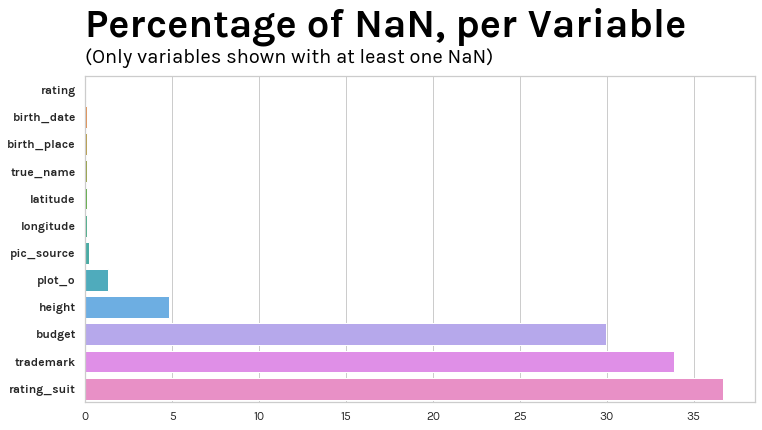

In [91]:
with open('data/pickle/master_df.pickle', 'rb') as handle:
    master_df = pickle.load(handle)

plt.figure(figsize=(12, 6))
missing_values = master_df.isnull().sum() / len(master_df) * 100
# only keep columns with missing values
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)
missing_values = missing_values.to_frame()
missing_values.columns = ['Percentage']
missing_values.index.names = ['Variable']
missing_values = missing_values.reset_index()
# missing_values['Name'] = miss.index
sns.set_style("whitegrid")
sns.barplot(x = 'Percentage', y = 'Variable', data=missing_values)
plt.title("Percentage of NaN, per Variable",
          fontdict=font_header,
          fontsize=40,
          loc='left',
          pad=40)
plt.text(
    0,
    -1,
    "(Only variables shown with at least one NaN)",
    fontdict=font_normal,
    fontsize=20)

plt.yticks(fontsize=12, family='Karla', weight='bold')
plt.xticks(fontsize=12, family='Karla')

plt.ylabel("")
plt.xlabel("")
plt.show()

Of the 42 variables in the final dataset, only 12 contain missing values. Three of them contain a large amount of missing data: Budget, actor trademark and rating suitability. 

In [809]:
with open('data/pickle/master_df.pickle', 'wb') as handle:
    pickle.dump(master_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Visualizing the Data

This part of my project is structured as follows:

1. First I look at the characteristics of actors:
    - How old are they?
    - Where do they come from?
    - What are their trademarks?
    - How are they connected?
2. Then, I take a closer look at the movies they play in:
    - Have movies become longer over time?
    - What is the relationship between rating, runtime and budget?
    - What genre should a movie have to get their actors nominated?

## Actors: How old are they?

What is the ideal age for an actor to be nominated or even win an Academy Award? And is it the same for men and women? The following will adress these questions.

In [92]:
# Plot nomination age by decade
with open('data/pickle/master_df.pickle', 'rb') as handle:
    master_df = pickle.load(handle)
# Reduce df to variables needed
age_plot = master_df[['year', 'gender', 'birth_date', 'winner']]
# drop rows with na for birthdate
age_plot = age_plot.dropna(subset=['birth_date'])
# create age at nomination (wrongly called win)
age_plot['birth_year'] = age_plot['birth_date'].astype(str).str[:4].astype(int)
age_plot['age_at_win'] = age_plot['year'] - age_plot['birth_year']

# create year rounded by base five to create lineplot with less spikes
# but preserve deviation ()
# Source function: https://stackoverflow.com/questions/40372030
def custom_round(x, base=10):
    """Function to round to costum base."""
    return int(base * round(float(x)/base))
age_plot = age_plot.dropna(subset=['year'])
age_plot['year_round'] = age_plot['year'].apply(lambda x: custom_round(x, base=5))
# look at data shape
age_plot.head(2)

,year,gender,birth_date,winner,birth_year,age_at_win,year_round
0,1927,male,1895-05-09,False,1895,32,1925
1,1927,male,1884-07-23,True,1884,43,1925


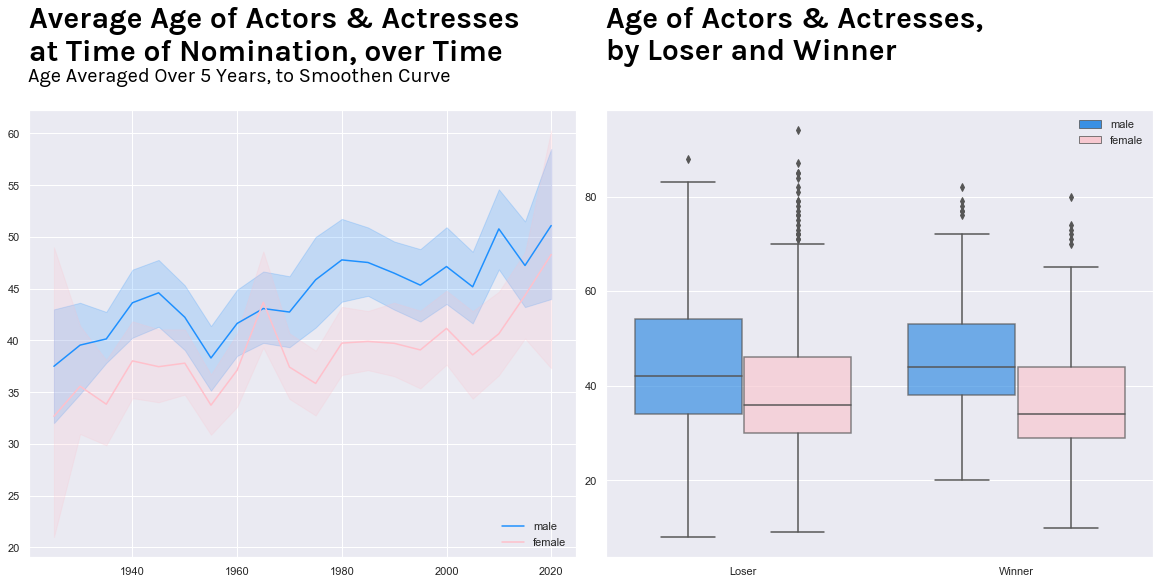

In [95]:
sns.set(style="darkgrid")
fig = plt.figure(constrained_layout=True, figsize=(16, 8))
gs = fig.add_gridspec(10, 10)

ax1 = fig.add_subplot(gs[:, :5])
ax2 = fig.add_subplot(gs[:, 5:])
# Load an example dataset with long-form data

# Plot the responses for different events and regions
sns.lineplot(x="year_round",
             y="age_at_win",
             hue="gender",
             data=age_plot,
             palette=["dodgerblue", "pink"],
             ax=ax1)

boxplot_1 = sns.boxplot(x="winner",
            y="age_at_win",
            hue='gender',
            palette=["dodgerblue", "pink"],
            data=age_plot,
            ax=ax2, boxprops=dict(alpha=.7))
# set titles
ax1.set_title("Average Age of Actors & Actresses \nat Time of Nomination, over Time",
              fontdict=font_header,
              fontsize=30,
              loc='left',
              pad=50)
ax2.set_title("Age of Actors & Actresses, \nby Loser and Winner",
              fontdict=font_header,
              fontsize=30,
              loc='left',
              pad=50)
ax2.set_xticklabels(("Loser", "Winner"))
ax1.text(1920,65,"Age Averaged Over 5 Years, to Smoothen Curve",
              fontdict=font_normal,
              fontsize=20)
ax1.set_ylabel("")
ax1.set_xlabel("")
ax2.set_ylabel("")
ax2.set_xlabel("")

# calculate median
medians_fem = age_plot.loc[age_plot['gender'] == 'female'].groupby(
    ['winner'])['age_at_win'].median()
medians_men = age_plot.loc[age_plot['gender'] == 'male'].groupby(
    ['winner'])['age_at_win'].median()

# format legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[1:], labels=labels[1:], loc='lower right', frameon=False)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles[0:2], labels=labels[0:], frameon=False)

# ax1.legend(, title="")
plt.show()
fig.savefig("foo.png", bbox_inches='tight', dpi=600)

In [20]:
print("Actresses Age Median\n" + "Loser:", medians_fem[0], "Winner:", medians_fem[1])
print("\nActors Age Median\n" + "Loser:", medians_men[0], "Winner:", medians_men[1])

Actresses Age Median
Loser: 36 Winner: 34

Actors Age Median
Loser: 42 Winner: 44


**Line Plot** Let's have a look at the plot on the right first. Two things are appearent immediately: 
1. The average age for both men and women to be nominated for an Academy Award has incrased over the years
2. Women are consistently younger than men at the time of nomination, although the size of the age gap varies over the years.


**Boxplots**
The boxplots confirm the observation made in the first diagram: Women are on average younger when they are nominated for an Academy Award. For both men and women, the median age for a win differs slightly from a non-win. Interestingly, women that win tend to be younger than the losers, however, for the men its the other way around: Winners tend to be older than losers.



## Actors: Where are they from?

The #oscarssowhite campaign by [April Reign](https://www.dailyemerald.com/arts-culture/the-oscar-problem-how-one-biased-organization-picks-the-best/article_e3ee09f6-3328-11e9-94e8-03b3bc73576f.html) brought the lack of diversity and intersectionality in the Academy Awards to the public consciousness in 2015. Across categories, a huge amount of nominees are usually white men. Of course, there will be no _nomination gender bias_ in the categories I am looking at. 

However, I will try to find some of the racial bias that once again was [criticized](https://www.nytimes.com/2020/01/14/us/oscar-nominations-women.html) when the Academy announced their nominees for 2020: All but one of the best actor and actress nominees were white.

To my knowledge, there is no dataset about the race of actors (not too surprising of course). However, the data allows me to look at the different birthplaces of actors. Of course, that is only a weak proxy for race - but it's the best I the data allows me to do.

In [21]:
with open('data/pickle/master_df.pickle', 'rb') as handle:
    master_df = pickle.load(handle)
birthplaces_df = master_df[['gender', 'actor_id','birth_place', 'latitude', 'longitude']] 
birthplaces_df = birthplaces_df.drop_duplicates(subset='actor_id')

birthplaces_df.head(1)
# create variable which combines lat & long so I can count the occurance of each place
birthplaces_df['lat_lon'] = birthplaces_df['latitude'].astype(str) + birthplaces_df['longitude'].astype(str) 
# calculate number of people from same place
value_counts = birthplaces_df['lat_lon'].value_counts()
value_counts = value_counts.to_frame().reset_index()
value_counts.columns = ['lat_lon', 'counts']

birthplaces_df = pd.merge(birthplaces_df, value_counts, how='left', on=['lat_lon'])
birthplaces_df = birthplaces_df.drop_duplicates(subset='lat_lon')
birthplaces_df.head(2)

,gender,actor_id,birth_place,latitude,longitude,lat_lon,counts
0,male,1932,"New York City, New York, USA",40.712775,-74.005973,40.7127753-74.0059728,76
1,male,417837,"Rorschach, St. Gallen, Switzerland",47.478882,9.491681,47.47888259.4916808,1


In [ ]:
# figure created with adapted code from:
# https://python-graph-gallery.com/315-a-world-map-of-surf-tweets/

my_dpi = 96
plt.figure(figsize=(2600 / my_dpi, 1800 / my_dpi), dpi=my_dpi)
m = Basemap(llcrnrlon=-180, llcrnrlat=-65, urcrnrlon=180, urcrnrlat=80)
m.fillcontinents(color='grey', alpha=0.3)
m.drawmapboundary(fill_color='#eefbfd', linewidth=0)


In [ ]:
birthplaces_df['gender_fac'] = pd.factorize(birthplaces_df['gender'])[0]

m.drawcoastlines(linewidth=0.1, color="white")
m.scatter(birthplaces_df['longitude'],
          birthplaces_df['latitude'],
          s=birthplaces_df['counts'] * 100,
          alpha=0.1,
          cmap="cool",
          c=birthplaces_df['gender_fac'])
plt.title("Birthplaces of Actors and Actresses",
          fontdict=font_header,
          fontsize=50,
          loc='left',
          pad=50)
plt.text(
    -160,
    -50,
    "Actors in blue, actresses in pink. \nSize of point represents number \nof people from same place",
    fontdict=font_normal,
    fontsize=20)
plt.show()

**Note:** My code for this plot worked until yesterday. However, if I run the code now, my kernel immediately dies with the error message `Assertion failed: (0), function query, file AbstractSTRtree.cpp, line 287.`. [This is apparently a known problem with the `GEOS` package ](https://github.com/Toblerity/Shapely/issues/490). Unfortunately, I had no time to fix the problem last minute. If you have the packages installed, it should run on your computer. I include an earlier version of my plot (without gender distingtion) in the markdown below.

<img src="world_map.png">

It is immediately apparent that a large amount of the actors and actresses were born in North America. There is a second accumulation in Europe, although significantly smaller. Hardly any actors come form the global south.

This is not too surprising, as there is a huge bias towards people of english mother tongue in the movie industry. However, even accepting this language bias, in 2010, [nearly 30% of the U.S. population were POC](http://worldpopulationreview.com/countries/united-states-population/) (self-reported). 

## Actors: What are their trademarks?

The IMDb has a category "trademark" in which the trademarks of specific actors and actresses are listed. For example, the trademark for Angelina Jolie is simply '*Full lips*' - for Christian Bale it is '*Often portrays obsessive and detached or loner characters*'.

What are the trademarks of actors and actresses that are nominated for an Academy Award? And is there a difference between the gender?

To find out, I create two seperate wordclouds: One for actors, one for actresses.

In [7]:
with open('data/pickle/master_df.pickle', 'rb') as handle:
    master_df = pickle.load(handle)
wordcloud_data = master_df[['actor', 'trademark', 'gender', 'actor_id']]

# delete rows with no trademark
print("Number of rows in the dataset:", wordcloud_data.shape[0])
wordcloud_data = wordcloud_data.drop_duplicates(subset='actor_id')
print("Number of rows after removing duplicate actor ID's:",
      wordcloud_data.shape[0])
wordcloud_data = wordcloud_data.dropna(subset=['trademark'])
print("Number of rows after removing actors with NA in trademark:",
      wordcloud_data.shape[0])

Number of rows in the dataset: 1728
Number of rows after removing duplicate actor ID's: 926
Number of rows after removing actors with NA in trademark: 512


In [21]:
# create data for plot
wordcloud_female = wordcloud_data[wordcloud_data['gender'] == 'female']
wordcloud_male = wordcloud_data[wordcloud_data['gender'] == 'male']
# combine all text's about women and men respectively
text_female = " ".join(trademark
                       for trademark in wordcloud_female.trademark).lower()
text_male = " ".join(trademark
                     for trademark in wordcloud_male.trademark).lower()
stopwords = set(STOPWORDS)
# add my own stopwords
stopwords.update([
    "often", 'known', 'frequently', 'always', 'playing', 'usually', 'film',
    'plays', 'played', 'often', 'Billy Wilder', 'work', 'sometimes'
])
# combine both text corpuses in one list
text_both = [text_female, text_male]
# look at data
text_both[0][:61]

'her mole enigmatic personality low and sensual voice waist-le'

In [25]:
# functions to color the wordclouds. idea from:
# https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html
def pink_color_func(word,
                    font_size,
                    position,
                    orientation,
                    random_state=None,
                    **kwargs):
    return "hsl(337,100%%, %d%%)" % random.randint(20, 80)


def blue_color_func(word,
                    font_size,
                    position,
                    orientation,
                    random_state=None,
                    **kwargs):
    return "hsl(194, 81%%, %d%%)" % random.randint(20, 80)


def display_wordcloud(words, titles, stopwords, n_components=2):
    """Function to print two wordclouds next to one another, inspired
    by this:
    https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html"""

    fig = plt.figure(figsize=(20, 10))
    j = 1
    color_functions = [pink_color_func, blue_color_func]
    # title_colors = ['palevioletred', 'steelblue']
    for t in range(n_components):
        i = t + 1
        plt.subplot(j, 2, i).set_title(titles[t],
                                       size=40,
                                       loc='left',
                                       family='Karla',
                                       fontweight='black',
                                       pad=40,
                                       color='black')
        # color=title_colors[t]

        plt.plot()
        plt.imshow(
            WordCloud(
                stopwords=stopwords,
                background_color="white",
                width=800,
                height=600,
                max_words=50,
                # tradeoff between word frequency (1) and
                # rank (0) for font size
                relative_scaling=0.1,
                collocations=True,
            ).generate(words[t]).recolor(color_func=color_functions[t],
                                         random_state=3), )
        plt.axis("off")
    # fig.suptitle(titles)
    plt.show()

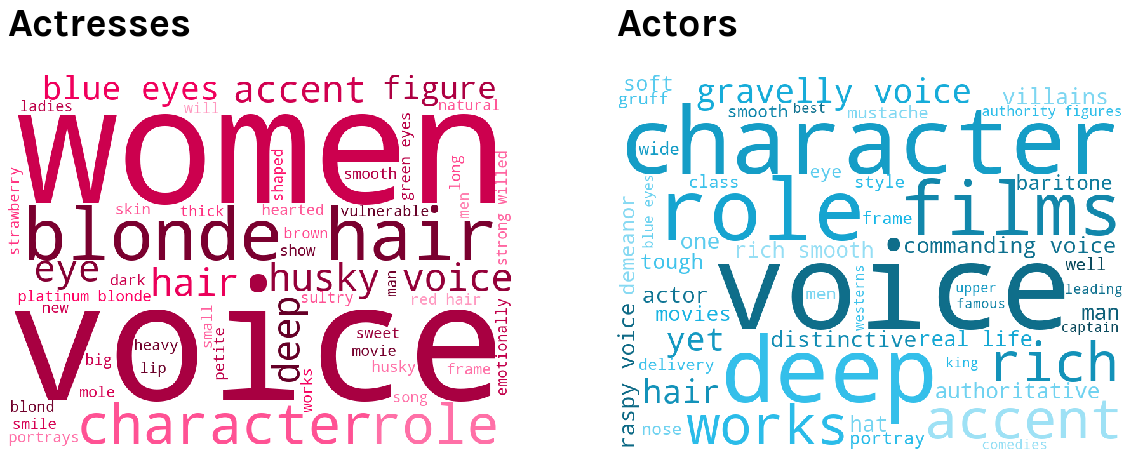

In [26]:
# Print wordclouds
titles = ['Actresses', 'Actors']
n_components = 2
display_wordcloud(text_both, titles, stopwords, n_components)

There are differences and similarities between the wordclouds. 

**Voice**: For both genders, their voice seems often to be a trademark. 
- Apparently, women are known for having **husky** voices, while men are known for having a **raspy, commanding or baritone** voice. 

**Physical features**: For both men and women, the wordclouds describe their physical features - however, there are differences.
- The trademarks of women are often physical feautures like haircolor, eyecolor, petite, shaped, thick, thin, skin, mole*
- Men's trademarks also include physical features (e.g. mustache, hair, hat, nose) but they appear less frequent and are less specific

**Non-physical features**: When it comes to non-physical features, there is a great difference between the genders:
- Women are described as strong willed, vulnerable, hearted and emotionally
- Men are described as authoritative, tough and leading

The wordclouds are not surprising to me: They nearly perfectly describe the existing gender stereotypes. 

## Actors: How are they connected?

Are there actors and actresses that are often nominated in movies alongside their coactors? To find out, I create a network plot that connects actors if they played in the same movie and were both nominated for an academy award.

In [53]:
pd.set_option('mode.chained_assignment', None)

with open('data/pickle/master_df.pickle', 'rb') as handle:
    master_df = pickle.load(handle)

# prepare data for network
network_data = master_df[['film_id', 'actor']]
network_data.head()
network_data['g'] = network_data.groupby('film_id').cumcount().astype(str)
network_data = network_data.pivot(index='film_id',
                                  columns='g').sort_index(axis=1, level=1)
network_data.columns = network_data.columns.map('_'.join)
network_data = network_data.reset_index()
# keep only the rows with at least two actors
network_data = network_data.dropna(subset=['actor_1']).drop(
    columns=['film_id'])

# create a dictionary to create the network with
network_values = network_data.values.tolist()

list_keys = []
for row in network_values:
    new_key = row[0]
    list_keys.append(new_key)
unique_keys = list(set(list_keys))

dict_network = dict.fromkeys(unique_keys)
for row in network_values:
    new_key = row[0]
    value = row[1:]
    value_clean = [x for x in value if str(x) != 'nan']
    dict_network[new_key] = value_clean

# create the network from dictionary (key to node, values to edges)
g = nx.Graph()
g.add_nodes_from(dict_network.keys())
for k, v in dict_network.items():
    g.add_edges_from(([(k, t) for t in v]))
g = nx.to_undirected(g)

# get degree of nodes
degree_dict = dict(g.degree(g.nodes()))
nx.set_node_attributes(g, degree_dict, 'degree')
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
# create list of top 10 most central nodes
central = []
for d in sorted_degree[:14]:
    central.append(d[0])

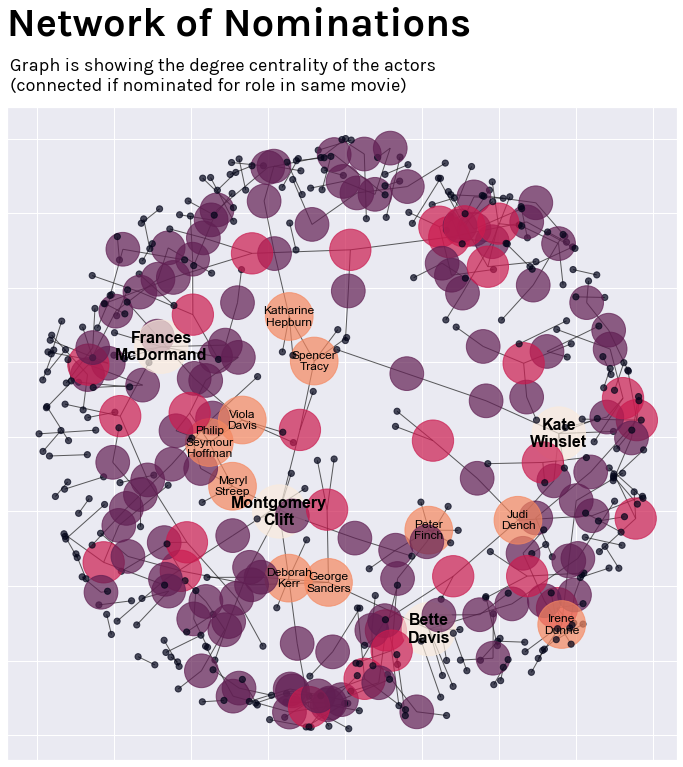

In [67]:
sns.set_color_codes("pastel")

central = []
for d in sorted_degree[:4]:
    central.append(d[0])

central2 = []
for d in sorted_degree[4:14]:
    central2.append(d[0])

# create labels for plot
labels = {}
for node in g.nodes():
    if node in central:
        new_name = node.replace(" ", "\n")
        labels[node] = new_name

labels2 = {}
for node in g.nodes():
    if node in central2:
        new_name = node.replace(" ", "\n")
        labels2[node] = new_name

# print plot
pos = nx.spring_layout(g, iterations=100, k=6 / math.sqrt(g.order()))
deg_cen = nx.degree_centrality(g)

# define color and size of edges based on their degree
node_color = [20000.0 * g.degree(v) for v in g]
node_size = [v * 300000 if v > 0.0019 else v * 20000 for v in deg_cen.values()]
plt.figure(figsize=(12, 12))
nx.draw_networkx(g,
                 pos=pos,
                 with_labels=False,
                 node_color=node_color,
                 node_size=node_size,
                 alpha=0.7,
                 edge_cmap='gist_rainbow')

nx.draw_networkx_labels(g,
                        pos,
                        labels,
                        font_size=16,
                        font_color='black',
                        font_weight='heavy',
                        family='Karla')

nx.draw_networkx_labels(g,
                        pos,
                        labels2,
                        font_size=12,
                        font_color='black',
                        font_weight='regular',
                        family='Karla')

plt.title('Network of Nominations \n',
          fontsize=40,
          weight='heavy',
          color='black',
          family='Karla',
          loc='left',
          pad=30)
plt.figtext(
    0.128,
    0.9,
    'Graph is showing the degree centrality of the actors \n(connected if nominated for role in same movie)',
    fontsize=18,
    family='Karla',
    ha='left',
    weight='normal',
    color='black')
plt.draw()
# plt.show()

The bigger a node is, the more often an actor / actress was nominated for an Academy Award alongside their co-actor/actress. A big node could mean two things or a combination of both: Either the person is truly talented and was nominated many times, increasing the chance of a nomination for a co-actors. Or, the person has excellent movie scrpit taste and tends to choose movies with roles that please the Academy jury.  

The plot only includes actors and actresses that have at least one connection. As this plot is a bit messy, I created a second plot showing the distribution of degrees.

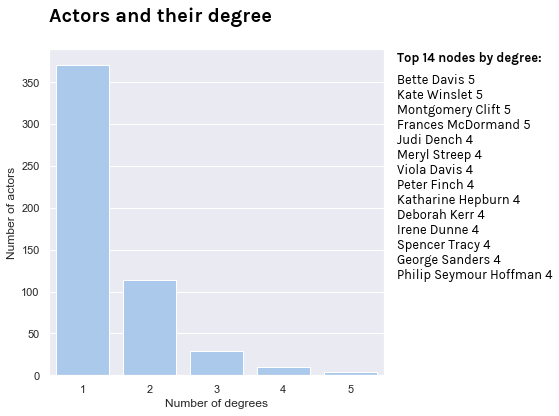

In [91]:
# create plot annotation
text_annotation = []
for person, number in sorted_degree[:14]:
    text_to_append = person + " " + str(number)
    text_annotation.append(text_to_append)
text_annotation = '\n'.join(text_annotation)
# text_annotation = "Top 10 nodes by degree:\n\n" + text_annotation
# prepare data
network_degree = pd.DataFrame(sorted_degree, columns=['Name', 'Degree'])
network_degree_plot = network_degree.groupby([network_degree['Degree']
                                              ]).count().reset_index()
# print plot
sns.set_color_codes("pastel")
fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x="Degree",
            y="Name",
            data=network_degree_plot,
            label="Total",
            color="b")
ax.text(4.7, 375, "Top 14 nodes by degree:" , fontsize=13, weight='heavy', fontdict=font_header)
ax.text(4.7, 115, text_annotation, fontsize=13, fontdict=font_normal)
plt.title('Actors and their degree\n',
          fontsize=20,
          weight='heavy',
          color='black',
          loc='left', fontdict=font_header)
plt.xlabel('Number of degrees')
plt.ylabel('Number of actors')
plt.show()

Among the actors that have at least one connection, most of them have only one single connection. This means that they once were nominated for an Academy Award alongside their co-actor.

## Movies: Have they become longer over time? 

Anyone who watched _Once Upon a Time in the West_ after the year 2000 would probably argue that movies _must have_ become shorter over time. But what does the data say?

In [86]:
with open('data/pickle/master_df.pickle', 'rb') as handle:
    master_df = pickle.load(handle)
duration = master_df[[
    'winner', 'film_id', 'runtime', 'rating', 'budget','year', 'drama', 'history', 'romance',  'crime', 'biography', 'gender'
]]
duration.head(2)

,winner,film_id,runtime,rating,budget,year,drama,history,romance,crime,biography,gender
0,False,19217,65,7.1,NaN,1927,True,False,False,False,False,male
1,True,19071,88,8.0,NaN,1927,True,True,True,False,False,male


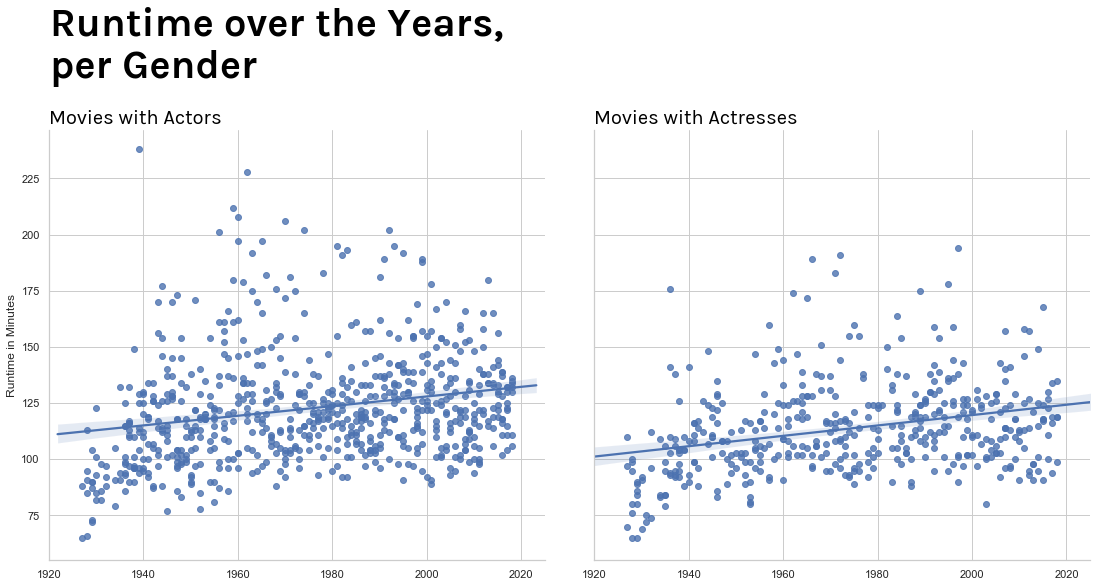

In [813]:
duration_dedu = duration.drop_duplicates(subset='film_id')

g = sns.lmplot(x="year",
               y="runtime",
               col="gender",
               data=duration_dedu[duration_dedu['runtime'] < 350],
               aspect=1.1, height=7).set_axis_labels("", "Runtime in Minutes")
fig = g.fig
fig.subplots_adjust(wspace=.1)
fig.suptitle("Runtime over the Years, \nper Gender", x=0.05,y=1.19,
              fontdict=font_header,
              fontsize=40, weight='black',
                ha = 'left')

ax1 = fig.axes[0]
ax2 = fig.axes[1]
ax2.set_xlim(1920, 2025)
ax1.set_title("Movies with Actors", 
              fontdict=font_normal,
              fontsize=20,
              loc='left',
              pad=15)
ax2.set_title("Movies with Actresses", 
              fontdict=font_normal,
              fontsize=20,
              loc='left',
              pad=15)
ax1.set_title("")
ax2.set_title("")
plt.show()

Apparently, movies _did not_ become shorter over time, their average runtime increased by about 20 minutes. Interstingly, the average movie duration for roles that got actresses nominated is shorter than the duration for men. 

## Movies: What is the relationship between rating, runtime and budget?

Including the budget variable in my analysis has two pitfalls. First, the variable contains a lot of missings and thus reduces the amount of data to analyze. The second problem is inflation. I can't solve the first problem. For the second, I used CPI data to adjust the budgets for inflation (to the value of 2017 dollars). However, this method is not perfect, so the results need to be interpreted with caution.

In [44]:
with open('data/pickle/master_df.pickle', 'rb') as handle:
    master_df = pickle.load(handle)
master_df = master_df.drop_duplicates(subset=['film_id', 'gender'])
rating_gender = master_df[[
    'winner', 'film_id', 'film', 'runtime', 'rating', 'budget','year', 'gender'
]]
rating_gender.head()
first  = rating_gender.shape[0]
rating_gender_budget = rating_gender.dropna(subset=['budget'])
second  = rating_gender_budget.shape[0]
print("Loss of rows because of NA's in budget variable:", first-second)
rating_gender_budget['budg_mil'] = rating_gender_budget['budget'] / 1000000
rating_gender_budget = rating_gender_budget.sort_values(by=['budg_mil'])
# adjust budgets to inflation
list_adj_prices = []
for index, row in rating_gender_budget.iterrows():
    new_price = cpi.inflate(row['budg_mil'], row['year'], to=2017)
    list_adj_prices.append(new_price)
rating_gender_budget['budg_adj'] = list_adj_prices
rating_gender_budget['titanic_dummy'] = None
rating_gender_budget.loc[(rating_gender_budget['film_id'] == 120338), 'titanic_dummy'] = True
rating_gender_budget = rating_gender_budget.sort_values(by='budg_adj', ascending=False)
rating_gender_budget.head(1)

Loss of rows because of NA's in budget variable: 445


,winner,film_id,film,runtime,rating,budget,year,gender,budg_mil,budg_adj,titanic_dummy
1302,False,120338,Titanic,194,7.8,200000000.0,1997,female,200.0,305.445483,True


In [45]:
rating_gender_budget.tail(1)

,winner,film_id,film,runtime,rating,budget,year,gender,budg_mil,budg_adj,titanic_dummy
1424,False,311648,Pieces of April,80,7.0,300000.0,2003,female,0.3,0.399652,None


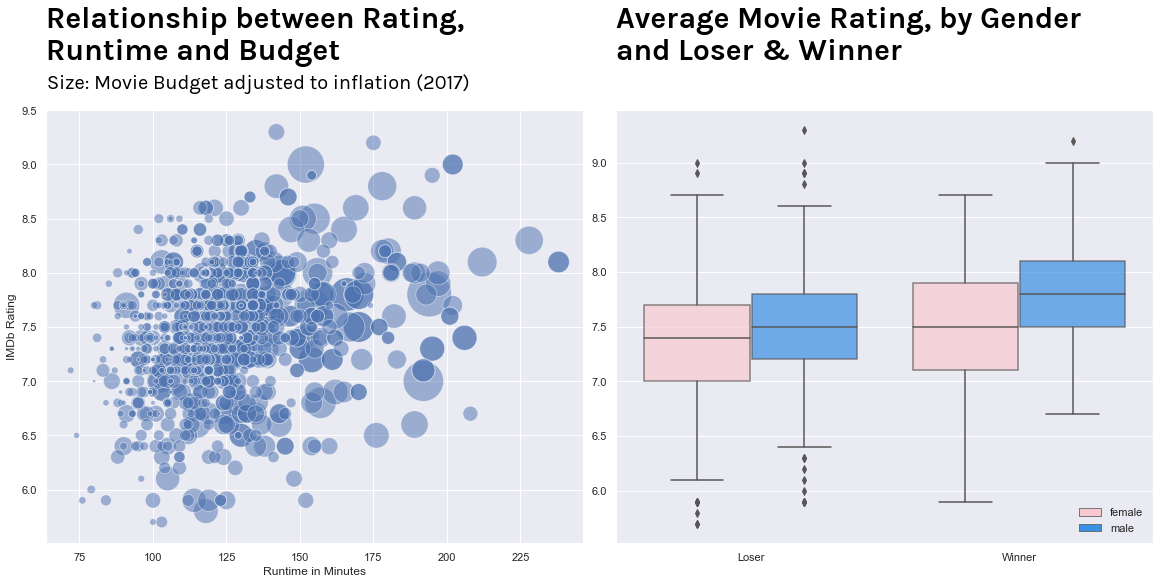

In [52]:
sns.set(style="darkgrid")
fig = plt.figure(constrained_layout=True, figsize=(16, 8))
gs = fig.add_gridspec(10, 10)

ax1 = fig.add_subplot(gs[:, :5])
ax2 = fig.add_subplot(gs[:, 5:])
# Load an example dataset with long-form data

# Plot the responses for different events and regions
sns.boxplot(x="winner",
            y="rating",
            hue='gender',
            palette=[ "pink", "dodgerblue"],
            data=rating_gender_budget,
            ax=ax2,
            boxprops=dict(alpha=.7))
p = sns.relplot(x="runtime",
            y="rating",
            size="budg_adj",
            sizes=(10, 2000),
            alpha=.5,
            palette="muted",
            height=8,
            data=rating_gender_budget,
            aspect=1,
            ax=ax1)

plt.close(p.fig)


# set titles
ax1.set_title("Relationship between Rating, \nRuntime and Budget",
              fontdict=font_header,
              fontsize=30,
              loc='left',
              pad=50)
ax2.set_title("Average Movie Rating, by Gender \nand Loser & Winner",
              fontdict=font_header,
              fontsize=30,
              loc='left',
              pad=50)
ax2.set_xticklabels(("Loser", "Winner"))
ax1.text(64,9.7,"Size: Movie Budget adjusted to inflation (2017)",
              fontdict=font_normal,
              fontsize=20)
ax1.set_ylabel('IMDb Rating')
ax1.set_xlabel("Runtime in Minutes")
ax2.set_ylabel("")
ax2.set_xlabel("")

# format legend

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles[0:2], labels=labels[0:], frameon=False, loc='lower right' )

# ax1.legend(, title="")
plt.show()

**Scatterplot:** It seems as there might be a slight correlation betwen rating and runtime. What is obvious, however, is that movies with greater budgets are longer - which makes a lot of sense. 

**Boxplot:** Apparently, men are nominated and win Awards for roles in higher rated movies than women. This might again stem from the problem of the general underrepresentation of women in movies: The academy might have less choice when they nominate actresses.

## Movies: What genre should a movie have to get their actors nominated?

There are always rumors about a genre bias at the Academy Awards. I will try to see if I can find it the nominations for actors.

However, this analysis is complicated by the fact that movies can have more than one genre. I will first adress this problem, before analyzing the nominations per genre. 


### The genre problem

The IMDb distingishes between 20 genres. As the movies can have more than one genre, in theory, there would be $2^{20}$ combinations of genres. Luckily, that is not the case, there are *only*  249 unique combinations in the dataset.

In [8]:
with open('data/pickle/master_df.pickle', 'rb') as handle:
    master_df = pickle.load(handle)
    
# drop movie duplicates
master_df = master_df.drop_duplicates(subset='film_id')

# reduce df to genre variables
genre_only = master_df[['drama', 'history', 'romance', 'war', 'crime',
    'film-noir', 'western', 'thriller', 'musical', 'biography', 'adventure',
    'comedy', 'mystery', 'family', 'sport', 'horror', 'sci-fi', 'fantasy',
    'music', 'action']]
# get all unique gender combinations
unique_combos = genre_only.groupby(['drama', 'history', 'romance', 'war', 'crime',
    'film-noir', 'western', 'thriller', 'musical', 'biography', 'adventure',
    'comedy', 'mystery', 'family', 'sport', 'horror', 'sci-fi', 'fantasy',
    'music', 'action']).size().reset_index().rename(columns={0:'count'})
# sort them by count
unique_combos = unique_combos.sort_values(by=['count'], ascending = False)
print("Number of unique genre combinations:", unique_combos.shape[0])

Number of unique genre combinations: 249


In [9]:
# create variable with genre combinations as stirng
list_genres = ['drama', 'history', 'romance', 'war', 'crime',
    'film-noir', 'western', 'thriller', 'musical', 'biography', 'adventure',
    'comedy', 'mystery', 'family', 'sport', 'horror', 'sci-fi', 'fantasy',
    'music', 'action']
genre_only['genre_combo'] = None
for genre in list_genres:
    unique_combos.loc[(unique_combos[genre] == True), genre] = genre
    unique_combos.loc[(unique_combos[genre] == False), genre] = None

    # get number of movies for each unique genre    
unique_combos_woc = unique_combos.drop(columns=['count'])
unique_combos_woc = unique_combos_woc.apply(
    lambda x: None if x.isnull().all() else ', '.join(x.dropna()), axis=1)
unique_combo_counter = pd.concat([unique_combos['count'], unique_combos_woc],
                                 axis=1,
                                 sort=False)
unique_combo_counter.columns = ['count', 'combos']
test = unique_combo_counter['count'].sum()
unique_combo_counter = unique_combo_counter.reset_index().drop(columns='index')
print("The table below shows the top 10 genre combinations.")
unique_combo_counter.head(10)

The table below shows the top 10 genre combinations.


,count,combos
0,165,drama
1,135,"drama, romance"
2,63,"drama, romance, comedy"
3,56,"drama, comedy"
4,38,"drama, biography"
5,26,"romance, comedy"
6,25,"drama, crime, thriller"
7,24,"drama, crime"
8,24,"drama, history, biography"
9,21,"drama, thriller"


### Concentration of movies in some genre combinations

It becomes evident from the table above that there is a concentration of movies with certain genre combinations. I will try to visualize this in the next two plots.

In [10]:
# I only want to keep drama, romance, comedy
venn_diagram = unique_combo_counter.loc[
    (unique_combo_counter['combos'] == 'drama')
    | (unique_combo_counter['combos'] == 'drama, romance')
    | (unique_combo_counter['combos'] == 'drama, romance, comedy')
    | (unique_combo_counter['combos'] == 'romance')
    | (unique_combo_counter['combos'] == 'comedy')
    | (unique_combo_counter['combos'] == 'romance, comedy')
    | (unique_combo_counter['combos'] == 'drama, comedy')]

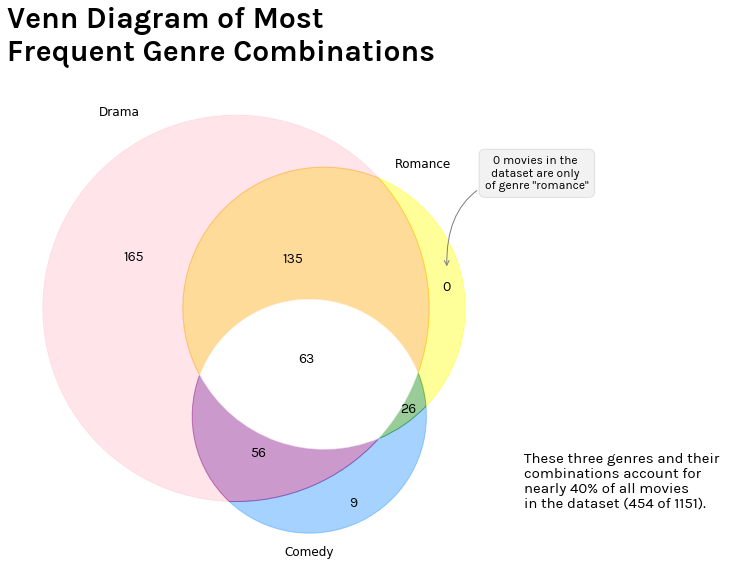

In [11]:
from matplotlib_venn import venn3
plt.figure(figsize=(9, 9))
v = venn3(subsets={
    '100': 165,
    '010': 0,
    '110': 135,
    '001': 9,
    '101': 56,
    '011': 26,
    '111': 63
},
          set_labels=('Drama', 'Romance', 'Comedy'))

v.get_patch_by_id('100').set_color('pink')
v.get_patch_by_id('010').set_color('yellow')
v.get_patch_by_id('001').set_color('dodgerblue')
v.get_patch_by_id('110').set_color('orange')
v.get_patch_by_id('101').set_color('purple')
v.get_patch_by_id('011').set_color('green')
v.get_patch_by_id('111').set_color('white')

for text in v.subset_labels:
    text.set_fontsize(14)
    text.set_family('Karla')

plt.title("Venn Diagram of Most \nFrequent Genre Combinations",
          fontdict=font_header,
          fontsize=30,
          loc='left',
          pad=20)
plt.text(
    0.7,
    -0.5,
    "These three genres and their \ncombinations account for \nnearly 40% of all movies \nin the dataset (454 of 1151).",
    fontdict=font_normal,
    fontsize=15)

plt.annotate('0 movies in the \ndataset are only \nof genre "romance"',
             family='Karla',
             fontsize=12,
             xy=v.get_label_by_id('010').get_position() - np.array([0, -0.05]),
             xytext=(90, 80),
             ha='center',
             textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->',
                             connectionstyle='arc3,rad=0.5',
                             color='gray'))
plt.show()

Drama is by far the biggest genre, and in combination with Romance and Comedy, nearly 40% of the movies in the dataset are dramas. This means that actors mostly get nominated for roles in movies that are i.a. of genre drama.

Interstingly, zero actors were nominated for a role in a movie that was solely of genre romance. Apparently, romantic movies tend to be eigher dramatic (drama) or funny (comdey). Of course, having zero movies of genre *romantic only* in the dataset could also mean that these movies generally do not allow actors to be nominated for an Academy Award (but I think this is the less likely scenario).

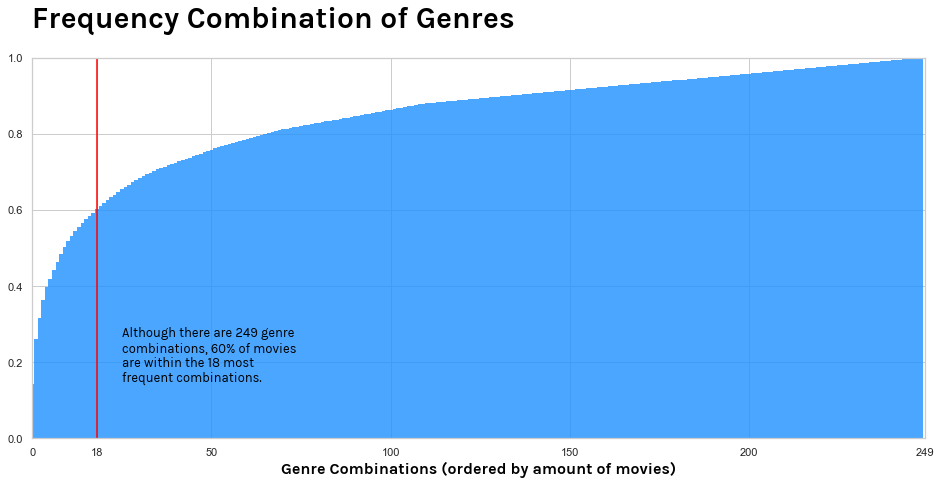

In [12]:
# get cumulative sum for genre combinations
unique_combo_counter['percentage'] = unique_combo_counter[
    'count'] / unique_combo_counter['count'].sum()
unique_combo_counter['per_cum_sum'] = unique_combo_counter[
    'percentage'].cumsum()
unique_combo_counter_perc = unique_combo_counter.loc[(
    unique_combo_counter['per_cum_sum'] <= 0.6)]
line60 = unique_combo_counter_perc.shape[0]
# plot data
width = 1
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(16, 7))

plt.bar(unique_combo_counter.index,
        unique_combo_counter['per_cum_sum'],
        width,
        edgecolor='none',
        color='dodgerblue',
        alpha=0.8)
plt.axvline(x=line60, color='red')
# sns.barplot(x='combos',
#             y="per_cum_sum",
#             data=unique_combo_counter)
ax.set_title("Frequency Combination of Genres",
             fontdict=font_header,
             fontsize=30,
             loc='left',
             pad=30)
ax.set_xlim(0, 249)
ax.set_ylim(0, 1)

ax.get_xaxis().set_ticks([0, line60, 50, 100, 150, 200, 249])
ax.text(
    25,
    0.15,
    "Although there are 249 genre \ncombinations, 60% of movies \nare within the 18 most \nfrequent combinations.",
    fontsize=13,
    fontdict=font_normal)
ax.set_xlabel("Genre Combinations (ordered by amount of movies)",
              fontdict=font_bold,
              fontsize=16)

plt.show()

The plot above compliments the Venn diagram: We see that, even though there are many combinations of genres, there is a large combination of movies in a small amount genre combinations. This means that there are _typical_ genre combinations.

### Nominations by Genre

Keeping in mind that the genres overlap in a great deal, I now look at the amount of nominations per genre, as it is not feasible to look at the amount of nomination per _genre combination_. 

In [14]:
with open('data/pickle/master_df.pickle', 'rb') as handle:
    master_df = pickle.load(handle)

# prepare data
genre_df = master_df[[
    'gender', 'winner', 'drama', 'history', 'romance', 'war', 'crime',
    'film-noir', 'western', 'thriller', 'musical', 'biography', 'adventure',
    'comedy', 'mystery', 'family', 'sport', 'horror', 'sci-fi', 'fantasy',
    'music', 'action'
]]
genre_per_year = genre_df.groupby(
    [genre_df['gender'],
     genre_df['winner']]).sum().unstack('gender').transpose().reset_index()
genre_per_year.columns = ['genre', 'gender', 'lost', 'won']
genre_per_year = genre_per_year.sort_values(by=['lost', 'won'],
                                            ascending=False)

genre_per_year['total'] = (genre_per_year['lost'] + genre_per_year['won'])
genre_per_year[
    'success'] = 100 / genre_per_year['total'] * genre_per_year['won']
genre_per_year.head(2)

,genre,gender,lost,won,total,success
0,drama,female,637.0,164.0,801.0,20.474407
1,drama,male,624.0,160.0,784.0,20.408163


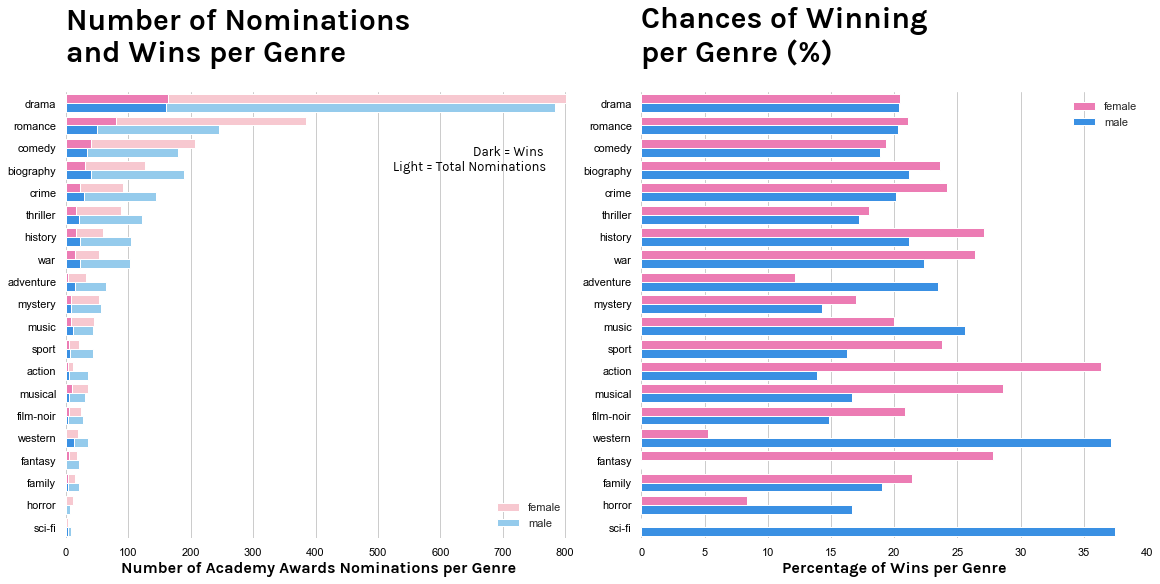

In [33]:
# plot figure
fig3 = plt.figure(constrained_layout=True, figsize=(16, 8))
gs = fig3.add_gridspec(10, 10)

ax1 = fig3.add_subplot(gs[:, :5])
ax2 = fig3.add_subplot(gs[:, 5:])

sns.set(style="whitegrid")

sns.barplot(x="total",
            y="genre",
            hue='gender',
            data=genre_per_year,
            palette=["pink", "lightskyblue"],
            ax=ax1)
sns.barplot(x="won",
            y="genre",
            hue='gender',
            data=genre_per_year,
            palette=["hotpink", "dodgerblue"],
            ax=ax1)
g = sns.barplot(x="success",
            y="genre",
            hue='gender',
            data=genre_per_year,
            palette=["hotpink", "dodgerblue"],
            ax=ax2)

ax1.legend(ncol=2, loc="lower right", frameon=False)
ax1.set(xlim=(0, 810), ylabel="")
ax1.set_title("Number of Nominations \nand Wins per Genre",
              fontdict=font_header,
              fontsize=30,
              loc='left',
              pad=30)
ax1.set_xlabel(
    "Number of Academy Awards Nominations per Genre",
    fontdict=font_bold,
    fontsize=16)

ax2.set(xlim=(0, 40), ylabel="")
ax2.set_xlabel("Percentage of Wins per Genre", fontdict=font_bold, fontsize=16)
ax1.tick_params(direction='out', length=6, width=2, colors='black',
               grid_color='black', grid_alpha=0.2)
ax2.tick_params(direction='out', length=6, width=2, colors='black',
               grid_color='black', grid_alpha=0.2)
ax2.set_title("Chances of Winning \nper Genre (%)",
              fontdict=font_header,
              fontsize=30,
              loc='left',
              pad=30)

# change legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[0:2], labels=labels[0:], frameon=False, loc='lower right' )

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles[0:2], labels=labels[0:], frameon=False, loc='upper right' )

ax1.text(
    770,
    3,
    "Dark = Wins \nLight = Total Nominations",
    fontsize=13,
    fontdict=font_normal, horizontalalignment='right')
sns.despine(left=True, bottom=True)

As we know from before, drama is the most popular movie genre in the dataset (alone and combined with other genres). This also means that most nominations are for roles in dramas - no surprise here (as the data only contains data about nominations). 

Two things, however, are interesting:

1. The plot on the right has to be interpreted with caution: For some genres, the number of nominations is pretty small which means that the rate of success could be a bit random. That being said, it becomes apparent that the success rates differ greatly per genre and per genre between genders. For example, there is a smaller absolute number of nominations for actresses in history or war movies. However, if they are nominated for movies with these genres, their success rate is higher than the one of men.

2. It appears as though actors are nominated for roles in a wider range of genres than actresses.

To illustrate the last point, I created another plot:

In [603]:
# create df females
genre_female = genre_per_year[genre_per_year['gender'] == 'female'].drop(columns=['gender', 'total', 'success'])
genre_female['nominations'] = (genre_female["loser"] + genre_female["winner"])
genre_female = genre_female.drop(columns=['loser', 'winner']).sort_values(by=['nominations'],  ascending=False)
genre_female['cumsum'] = genre_female['nominations'].cumsum()
genre_female_cumsum = genre_female.reset_index().drop(columns='index')
genre_female_cumsum['percentage'] = genre_female_cumsum[
    'nominations'] / genre_female_cumsum['nominations'].sum() * 100
genre_female_cumsum['per_cumsum'] = genre_female_cumsum['percentage'].cumsum()
# create df males
genre_male = genre_per_year[genre_per_year['gender'] == 'male'].drop(columns=['gender', 'total', 'success'])
genre_male['nominations'] = (genre_male["loser"] + genre_male["winner"])
genre_male = genre_male.drop(columns=['loser', 'winner']).sort_values(by=['nominations'],  ascending=False)
genre_male['cumsum'] = genre_male['nominations'].cumsum()
genre_male_cumsum = genre_male.reset_index().drop(columns='index')
genre_male_cumsum['percentage'] = genre_male_cumsum[
    'nominations'] / genre_male_cumsum['nominations'].sum() * 100
genre_male_cumsum['per_cumsum'] = genre_male_cumsum['percentage'].cumsum()

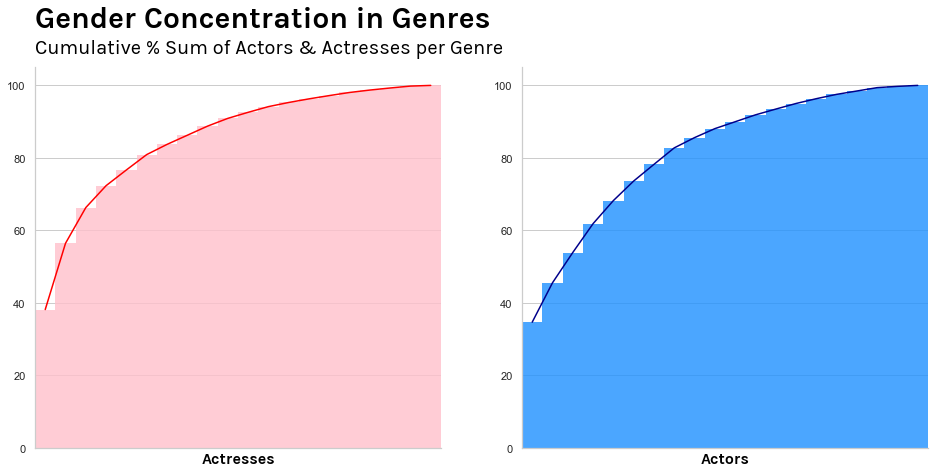

In [720]:
# create plot
width = 1
fig, ax = plt.subplots(ncols=2, figsize=(16, 7))

ax[0].bar(genre_female_cumsum.index,
          genre_female_cumsum['per_cumsum'],
          width,
          edgecolor='none', color='pink', alpha=0.8)
ax[0].plot(genre_female_cumsum.index,
           genre_female_cumsum['per_cumsum'],
           marker='',
           color='red',
           linewidth=1.5, alpha=1)
ax[0].set_xlim(-0.5,19.5)
ax[0].get_xaxis().set_ticks([])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_xlabel("Actresses",
              fontdict=font_header,
              fontsize=16)

# second plot
ax[1].bar(genre_male_cumsum.index,
          genre_male_cumsum['per_cumsum'],
          width,
          edgecolor='none', color='dodgerblue', alpha=0.8)
ax[1].plot(genre_male_cumsum.index,
           genre_male_cumsum['per_cumsum'],
           marker='',
           color='darkblue', 
           linewidth=1.5, alpha=1)
ax[1].set_xlim(-0.5,19.5)
ax[1].get_xaxis().set_ticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xlabel("Actors",
              fontdict=font_header,
              fontsize=16)

ax[0].set_title("Gender Concentration in Genres",
              fontdict=font_header,
              fontsize=30,
              loc='left',
              pad=40)
ax[0].text(-0.5,109,"Cumulative % Sum of Actors & Actresses per Genre",
              fontdict=font_normal,
              fontsize=20)
plt.show()

The plot above illustrates an observation from the plot before: Men are nominated for roles in a wider range of genres than women. This could either mean that the Academy judges only likes to see women in _some_ genres. 

[However, there are generally more men than women in movies.](https://www.theguardian.com/film/2018/aug/14/female-characters-outnumbered-by-male-hollywood-films) So the lack of women in some genres probably just shows the overall lack of gender parity in the movie industry.

# Classification 

My data is not very suitable to use a classification model on it. An obvious and logical option would be to classify whether an actor has won or lost.  Unfortunately, this doesn't work with my explanatory variables.  Even if I include the movie description as a Documentterm Matrix, it is not enough to be better than a model that simply predicts "did not win" for every observation. 

However, as the EDA showed, there is often a difference between genders (e.g.  age at win, movie duration, rating). Thus, I try to predict gender with these variables.

In [73]:
with open('data/pickle/master_df.pickle', 'rb') as handle:
    master_df = pickle.load(handle)
actors = master_df.drop_duplicates(subset='actor_id')
num_act = actors.shape[0]
num_fem = actors.loc[actors['gender']=='female'].shape[0]
num_men = actors.loc[actors['gender']=='male'].shape[0]
print("Number of actors:", num_act)
print("Number of actors:", num_men)
print("Number of actresses:", num_fem)
print("Percentage of Men:", num_men/num_act)

Number of actors: 926
Number of actors: 467
Number of actresses: 459
Percentage of Men: 0.5043196544276458


As we see above, the outcome variable is very balanced. There are slightly more men, so a simple model would predict all people to be men. However, it would be wrong in 49.5% of the cases.

In [74]:
# First, I drop all the columns that contain of strings, drop all rows with missings 
# and make sure all the resulting columns are of numeric type.

# to categorical
master_df["award"] = master_df["award"].astype('category')
master_df["award_cat"] = master_df["award"].cat.codes
master_df["gender_new"] = None
master_df.loc[(master_df['gender'] == "female"), 'gender_new'] = True
master_df.loc[(master_df['gender'] == "male"), 'gender_new'] = False

# change datetime - create age at win instead of birthdate
master_df = master_df.dropna(subset=['birth_date'])
master_df['birth_year'] = master_df['birth_date'].astype(str).str[:4]
master_df['birth_year'] = pd.to_numeric(master_df['birth_year'])
master_df['age_at_win'] = master_df['year'] - master_df['birth_year']

# create dataframe
predict_gender_data = master_df[[
    'gender_new', 'age_at_win', 'rating', 'runtime', 'drama', 'history', 'romance', 'war', 'crime',
    'film-noir', 'western', 'thriller', 'musical', 'biography', 'adventure',
    'comedy', 'mystery', 'family', 'sport', 'horror', 'sci-fi', 'fantasy',
    'music', 'action'
]]
print(predict_gender_data.shape)
predict_gender_data = predict_gender_data.dropna()
print(predict_gender_data.shape)
data_type = predict_gender_data.dtypes
#print('Data type of each column of Dataframe :')
# print(data_type)

(1726, 24)
(1725, 24)


In [83]:
np.random.seed(100)
y = predict_gender_data.gender_new==True
X = predict_gender_data.drop(['gender_new'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [87]:
classifier_names = ["Logistic Regression"]

classifiers = [LogisticRegression(C=1., solver='liblinear')]

pred_prob = {}
pred = {}

# fit individual classifiers
for name, classifier in zip(classifier_names, classifiers):
    np.random.seed(100)
    classifier.fit(X_train,y_train)
    pred_prob[name] = classifier.predict_proba(X_test)[:,1]
    pred[name] = np.where(pred_prob[name] >= 0.5, 1, 0)    

In [88]:
print("Confusion Matrix:\n")
cm = confusion_matrix(y_test, pred['Logistic Regression'])
print(cm)

print("\n [# negative examples, # positive examples] = ", np.sum(cm, 1))

Confusion Matrix:

[[113  52]
 [ 60 120]]

 [# negative examples, # positive examples] =  [165 180]


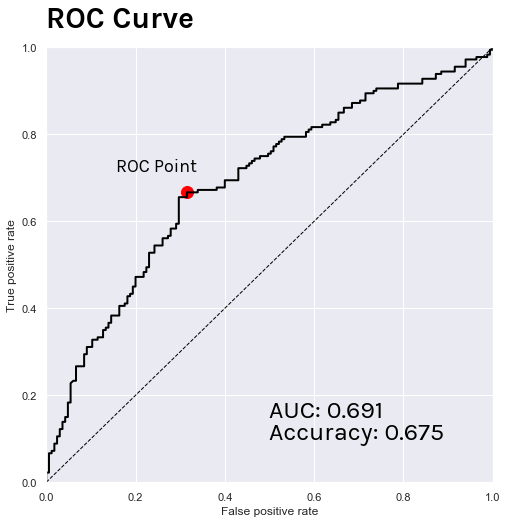

In [89]:
auc_value = auc(fpr, tpr)
tn, fp, fn, tp = cm.ravel()
fpr_pt = fp / (tn + fp)
tpr_pt = tp / (tp + fn)
fpr, tpr, _ = roc_curve(y_test, pred_prob['Logistic Regression'])

plt.subplots(figsize=(8, 8))
plt.plot(fpr_pt, tpr_pt, marker='o', color='red', label='Logistic Regression', markersize=12)
plt.plot(fpr, tpr, lw=2, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')

plt.xlabel("False positive rate")
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.ylabel("True positive rate")
plt.text(0.5,
         0.15,
         "AUC: %1.3f" % auc_value,
         fontsize=25,
         family='Karla',
         ha='left',
         weight='normal',
         color='black')
plt.text(0.5,
         0.1,
         "Accuracy: %.3f" %
         accuracy_score(y_test, pred['Logistic Regression']),
         fontsize=25,
         family='Karla',
         ha='left',
         weight='normal',
         color='black')
plt.text(fpr_pt-0.16, 0.05+tpr_pt, 
         "ROC Point",
         fontsize=18,
         family='Karla',
         ha='left',
         weight='normal',
         color='black')
plt.title('ROC Curve',
          fontsize=30,
          weight='heavy',
          color='black',
          loc='left', family='Karla', pad=20)
plt.show()

As discussed in the beginning, a simple model that just predicted 'male' for every observation would be right in about 50% of the cases. Linear regression that uses 'age_at_win', 'rating', 'runtime', and 'genres' classyfies nearly 70% of the observations correctly.

This reflects what we learned in the EDA: There are differences for men and women in age at win, rating of movies, duration of movies and the genres of the movies they play in. 

# Conclusion

## Key Findings

The EDA revealed some interesting patterns:

- **Characteristics of actors & actresses:**
    - On average, women are younger than men when they are nominated for Academy Awards 
    - With few exceptions, most nominated actors come from North America and Europe
    - Actors and actresses trademarks - the traits they are known for - reflect existing gender stereotypes. 
    - Some actors tend to be nominated more often alongside their co-actors than others. 


- **Characteristics of movies:**
    - On average, movies became longer. Women tend to be nominated for roles in shorter movies than men.
    - There might be a connection between rating and runtime, to confirm this, more analysis is needed.
    - Actors are nominated for movies in a wider range of genres than actresses.
    - There are typical genres and genre combinations, such as drama, romantic drama or comedy drama which make up for a large amount of nominations.

## Outlook

This EDA could be extended in multiple ways: First of all, I could not analyze all the data I scraped. It would be interesting to look into the connection of actors with the cast data of the movies. It would also be interesting to take a look into the director data.

Of course, the analysis could be extended to include more data: It would be interesting to look at a wider range of categories or to compare different awards, such as the Golden Globes or even the Razzies. It would be interesting to build a model that can predict the winners in each category. 

I planned to include more categories in my data. Unfortunately, the data aquisition and cleaning took much longer than expected. 